# Subspace Digital Twin, Parameter Selection Under Uncertainty

*BlockScience, April 2024*

Here we execute the PSUU framework for the subspace economic model. 

For more information see the methodology document by Danilo: https://hackmd.io/iFeP7NemRH--KtWbPP_W0w?view

## Part 1. Architecture Overview

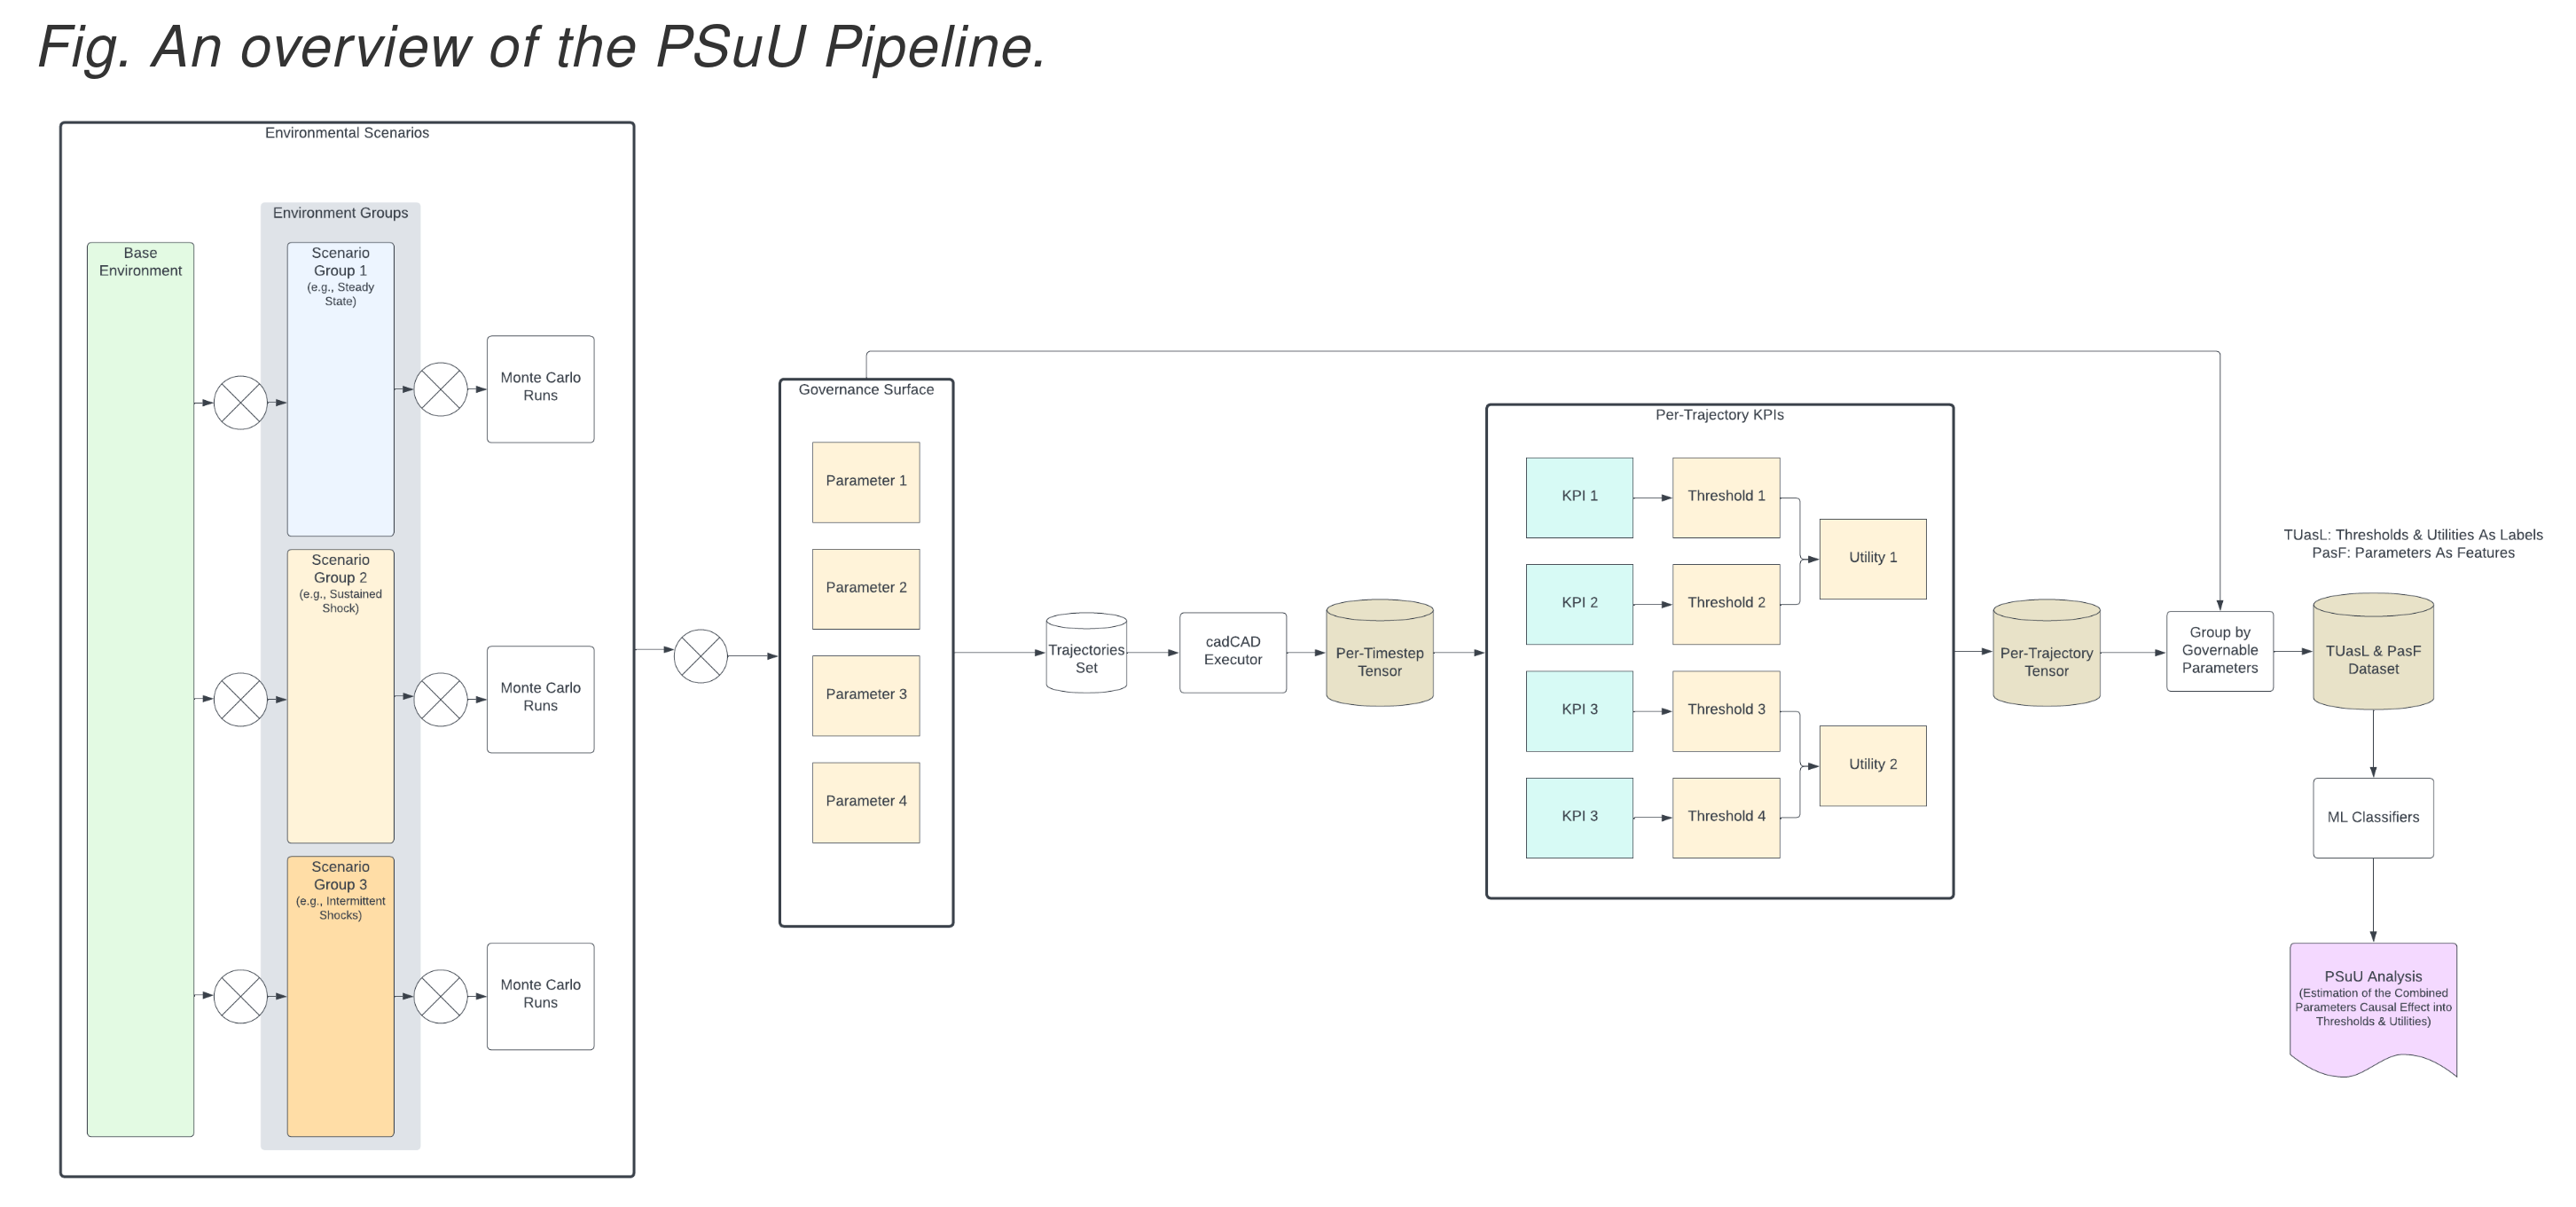

## Part 2. Loading and Cleaning the Per-Timestep Tensor

In [1]:
import sys
sys.path.append('../../')

import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import hvplot.pandas
import holoviews as hv
from typing import Callable, Dict, List, Tuple, Union

from subspace_model.psuu.plots import create_decision_tree_importances_plot
from subspace_model.psuu import timestep_tensor_to_trajectory_tensor, GOVERNANCE_SURFACE_PARAMS
from subspace_model.psuu.kpis import KPI_functions, calculate_goal_score, GOAL_KPI_GROUPS

In [2]:
pd.set_option('display.max_columns', None)

latest = sorted(glob("../../data/simulations/psuu-2024*"))[-1]

sim_df = pd.read_pickle(latest, compression='gzip')

N_sweeps = len(sim_df.subset.unique())
N_runs = len(sim_df.run.unique())
N_trajectories = N_sweeps * N_runs
N_timesteps = len(sim_df.timestep.unique())
N_measurements = N_trajectories * N_timesteps

print(f"Tensor Size: {N_measurements=:,} over {N_trajectories=:,} | ({N_sweeps=:,}, {N_runs=:,}, {N_timesteps=:,})\t")

Tensor Size: N_measurements=4,388,000 over N_trajectories=4,000 | (N_sweeps=200, N_runs=20, N_timesteps=1,097)	


In [3]:
sim_df.days_passed.max()

1096.0

Aggregating trajectories.

In [4]:
agg_df = timestep_tensor_to_trajectory_tensor(sim_df).reset_index()
agg_df.set_index(GOVERNANCE_SURFACE_PARAMS+['subset', 'run']).describe()

simulation  mean_relative_community_owned_supply  \
count       200.0                            200.000000   
mean          0.0                              1.177347   
std           0.0                              0.007177   
min           0.0                              1.163348   
25%           0.0                              1.172553   
50%           0.0                              1.176244   
75%           0.0                              1.182340   
max           0.0                              1.190256   

       mean_farmer_subsidy_factor  \
count                  200.000000   
mean                     0.998043   
std                      0.001901   
min                      0.989707   
25%                      0.997560   
50%                      0.998676   
75%                      0.999281   
max                      0.999697   

       mean_proposing_rewards_per_newly_pledged_space  \
count                                    2.000000e+02   
mean                                     5.758442e-13   
std                                      3.040859e-13   
min                                      8.961207e-14   
25%                                      3.586557e-13   
50%                                      5.635569e-13   
75%                                      7.964413e-13   
max                                      1.451348e-12   

       mean_proposer_reward_minus_voter_reward  cumm_rewards_before_1yr  \
count                               200.000000             2.000000e+02   
mean                              27189.448080             4.027719e+07   
std                               17389.310256             1.858385e+07   
min                                3198.711930             7.896586e+06   
25%                               13623.089278             2.631515e+07   
50%                               23256.662603             4.207694e+07   
75%                               38378.016483             5.785419e+07   
max                               80674.823392             7.380094e+07   

       abs_sum_storage_fees_per_sum_compute_fees  cumm_rewards  
count                                      200.0  2.000000e+02  
mean                                         1.0  1.008852e+08  
std                                          0.0  5.052904e+07  
min                                          1.0  1.843001e+07  
25%                                          1.0  6.782201e+07  
50%                                          1.0  1.053174e+08  
75%                                          1.0  1.291022e+08  
max                                          1.0  2.212507e+08

Kernal density estimate plots of KPI outcomes over trajectories.

Evaluating the utility tensor.

In [5]:


# Type alias for a Criterion function
Criterion = Callable[[float, pd.Series], bool]

def evaluate(x: pd.Series, data: pd.DataFrame, success_criteria: Union[str, Criterion]) -> pd.Series:
    col_name = x.name  # Assuming col_name comes from the Series name
    if isinstance(success_criteria, str):
        if success_criteria == 'smaller_than_median':
            y = data.loc[:, col_name] < data.loc[:, col_name].median()
        elif success_criteria == 'larger_than_median':
            y = data.loc[:, col_name] > data.loc[:, col_name].median()
        else:
            raise Exception('Criteria not specified')
    else:
        y = data[col_name].map(lambda z: success_criteria(z, data[col_name]))
    return y

utility_dfs: List[pd.DataFrame] = []
for kpi, (kpi_f, threshold_f) in KPI_functions.items():
    kpi_df = agg_df[[kpi]]
    utility_df = kpi_df.apply(lambda x: evaluate(x, agg_df, threshold_f))
    utility_df.name = kpi
    utility_dfs.append(utility_df)

utility_df: pd.DataFrame = pd.concat(utility_dfs, axis=1).astype(int)
utility_df.index = agg_df.set_index(GOVERNANCE_SURFACE_PARAMS+['simulation', 'subset', 'run']).index

In [6]:
utility_df.reset_index(drop=True)
utility_df.groupby('subset').mean().hvplot.heatmap(rot=25, height=800, width=1000, fontscale=1, cmap='RdYlGn', title='Utility outcomes by Parameter Subset', ylabel='Parameter Subset', xlabel='KPI Utility')

:HeatMap   [columns,index]   (value)

### Parameter Effect into System Goals

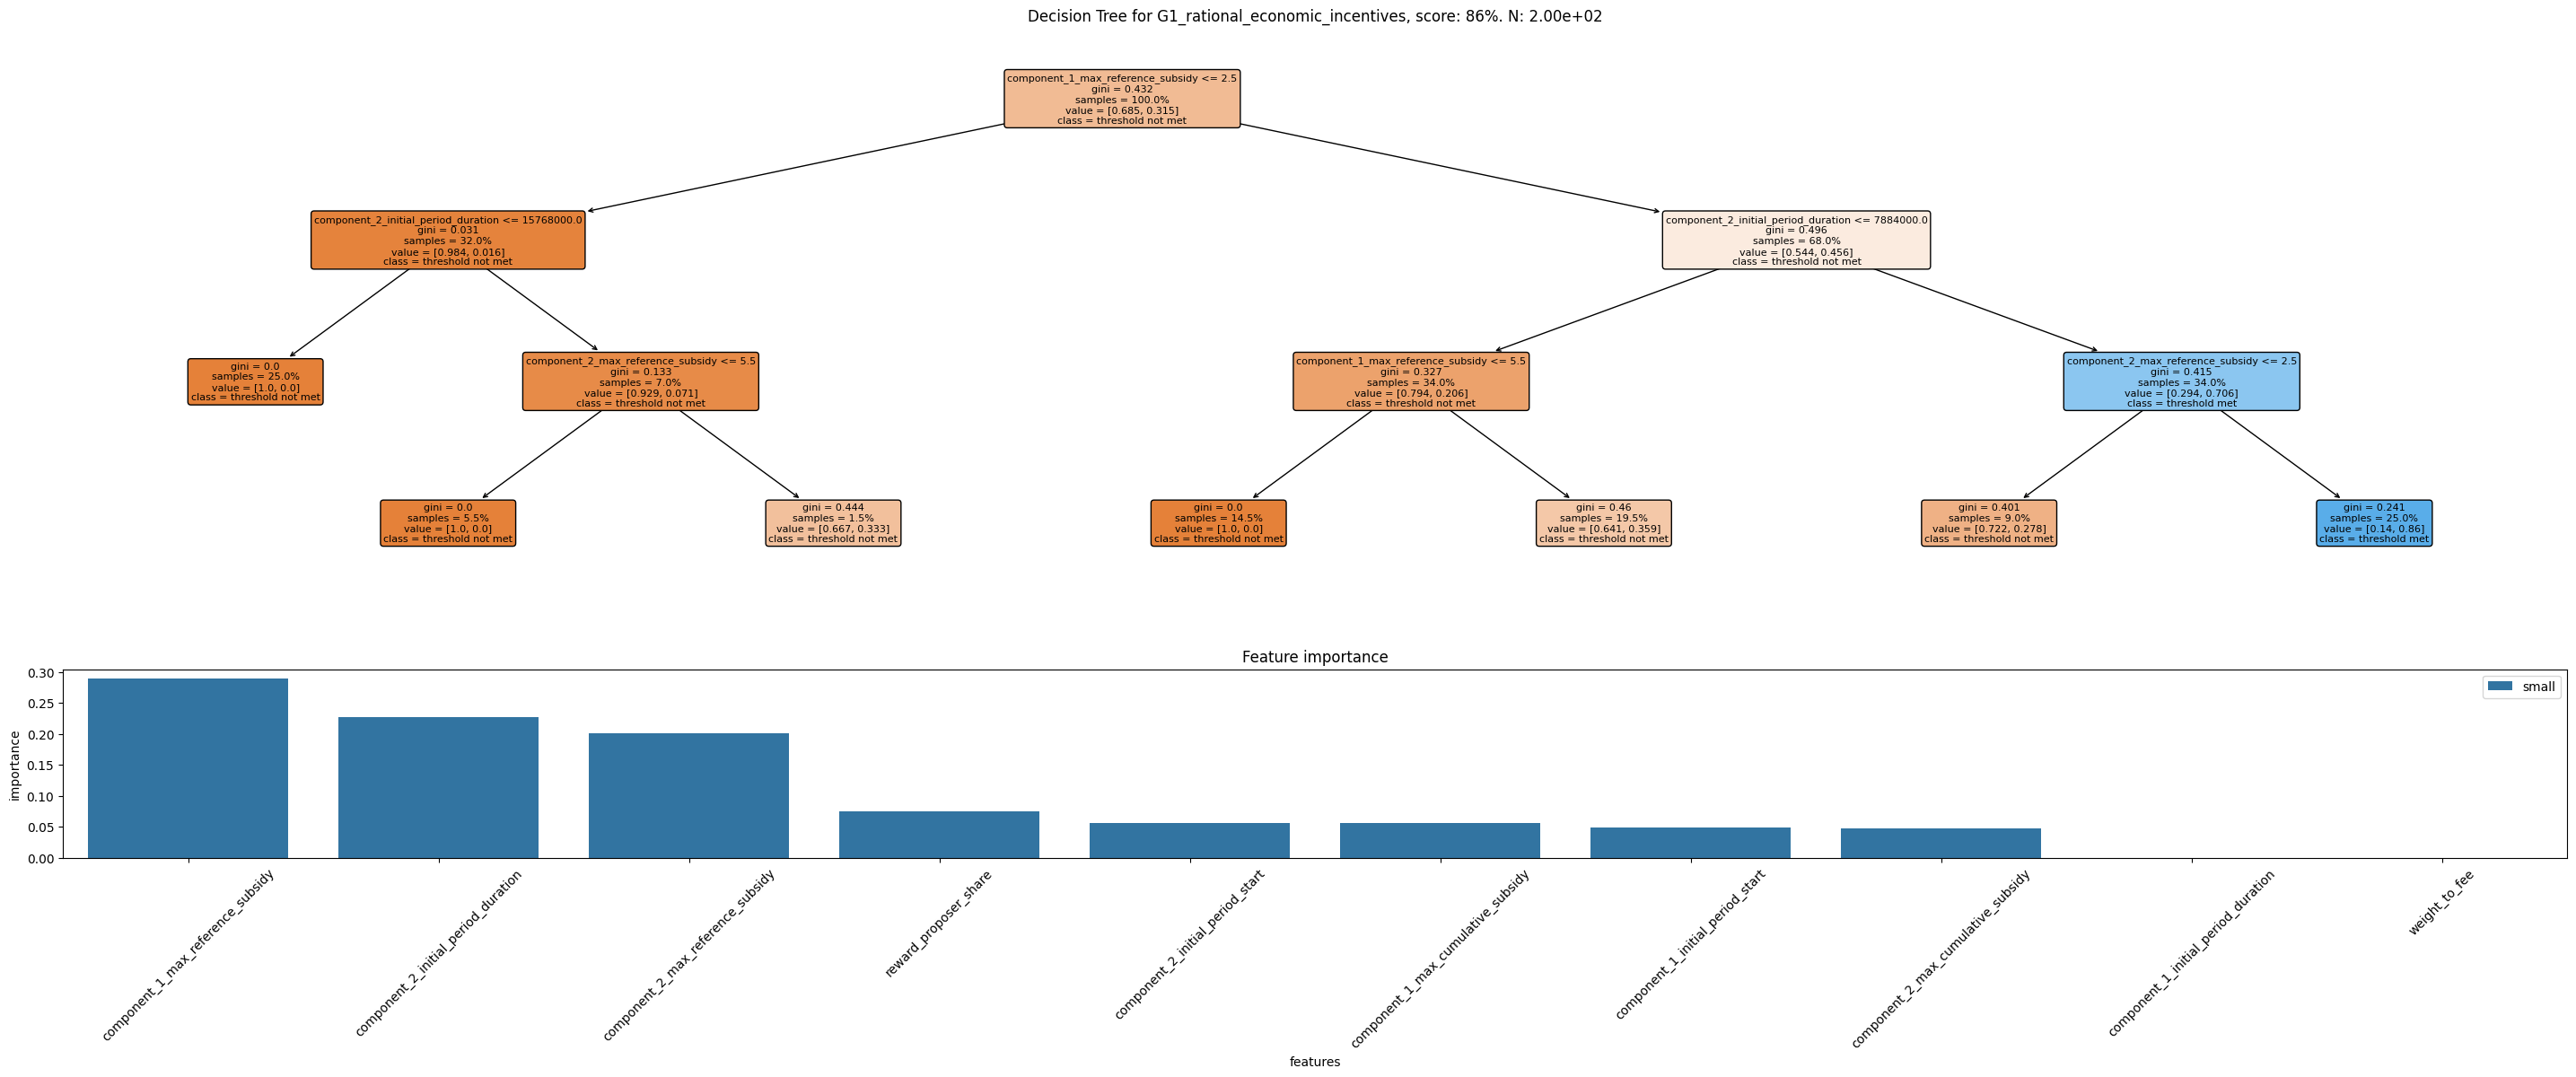

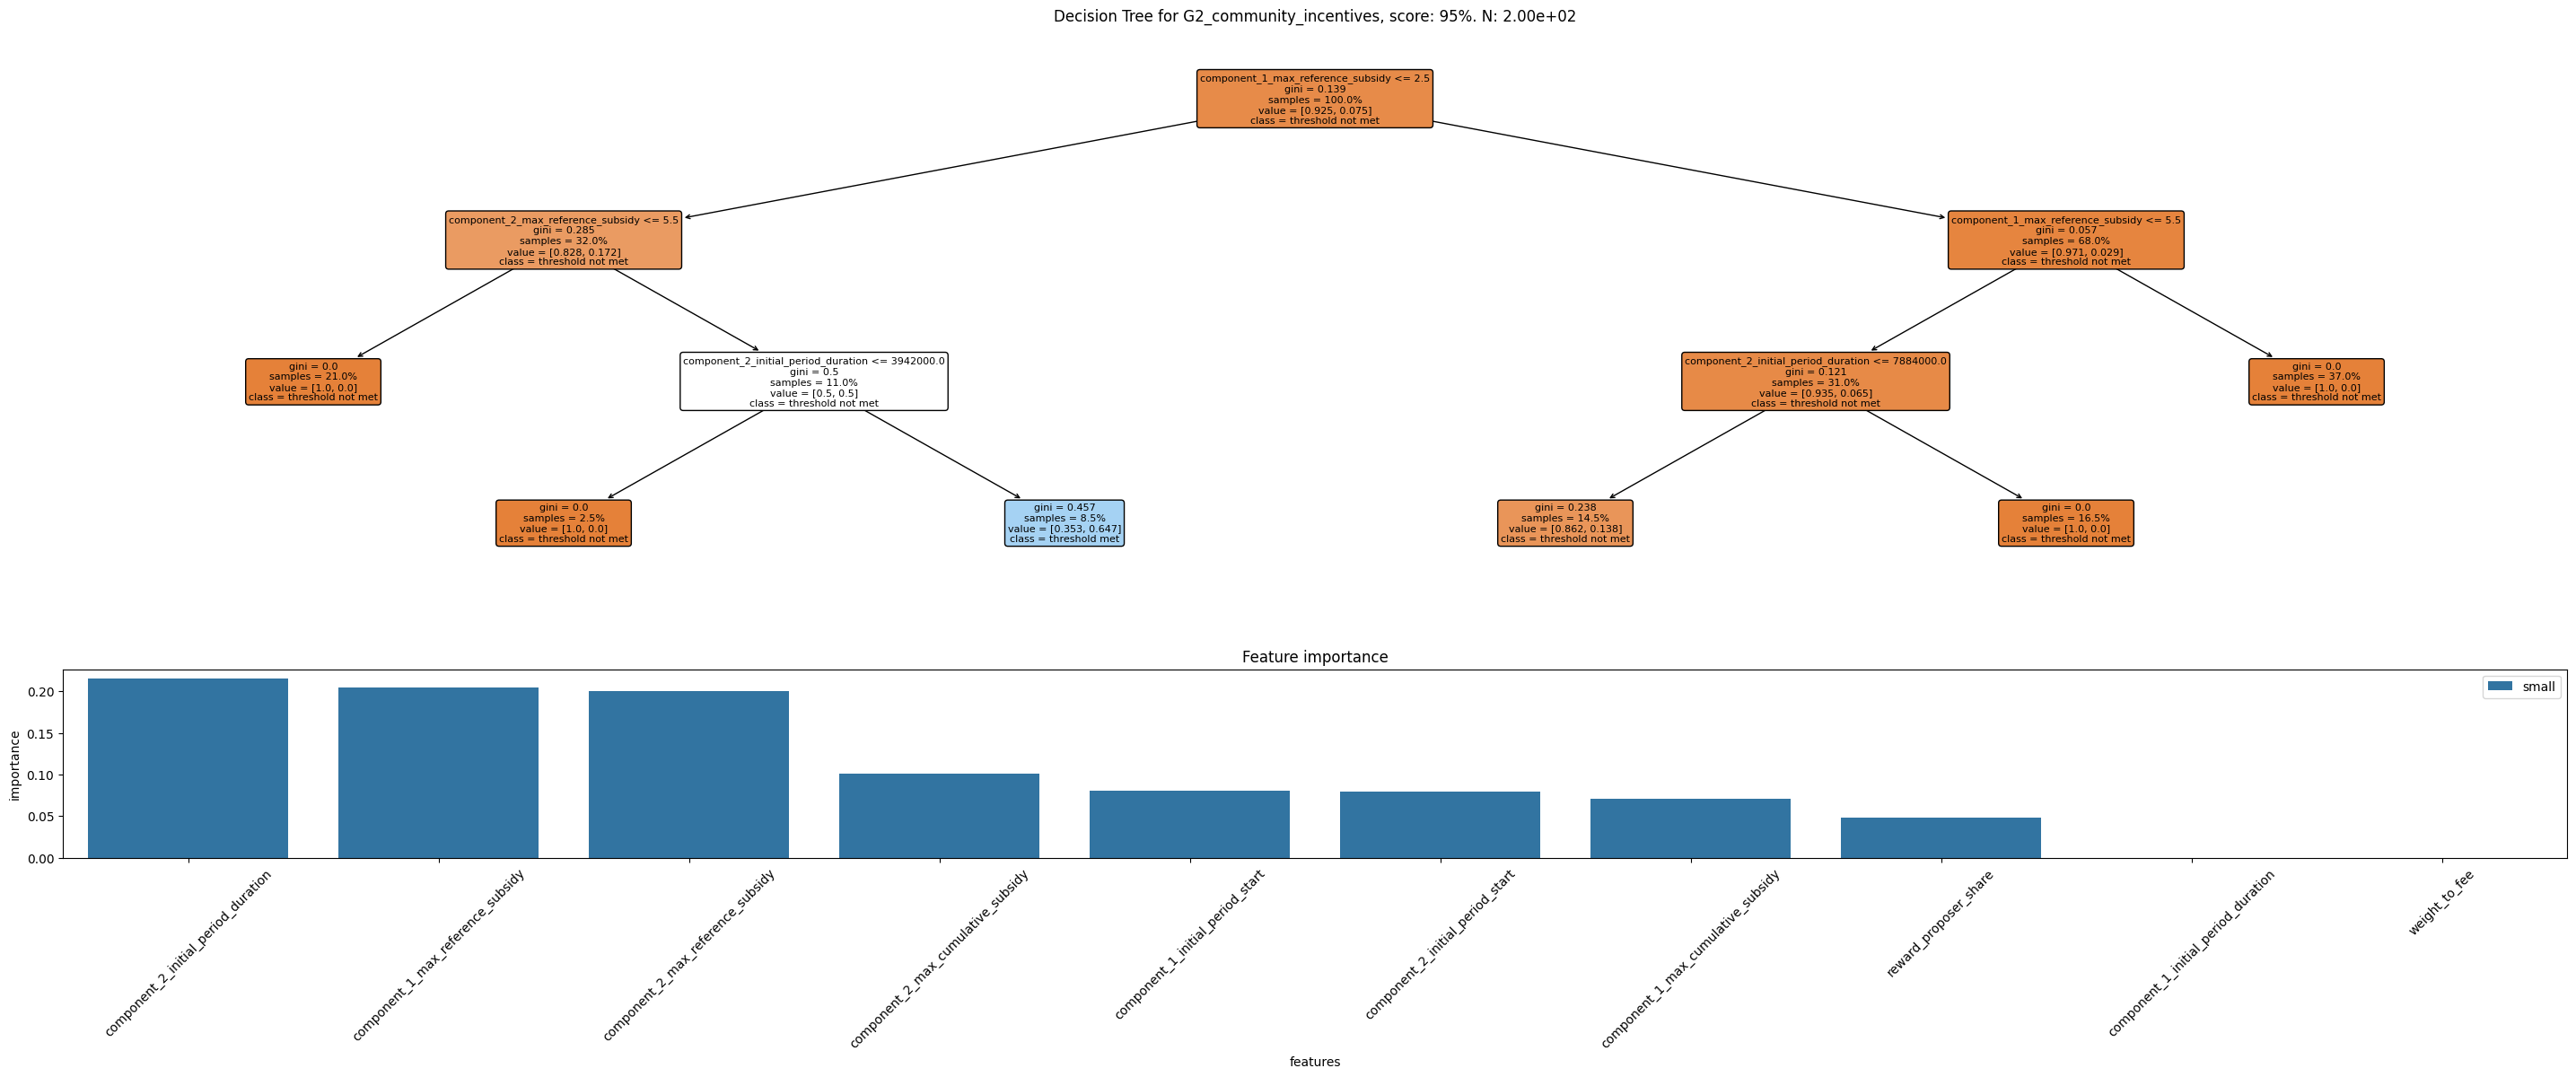

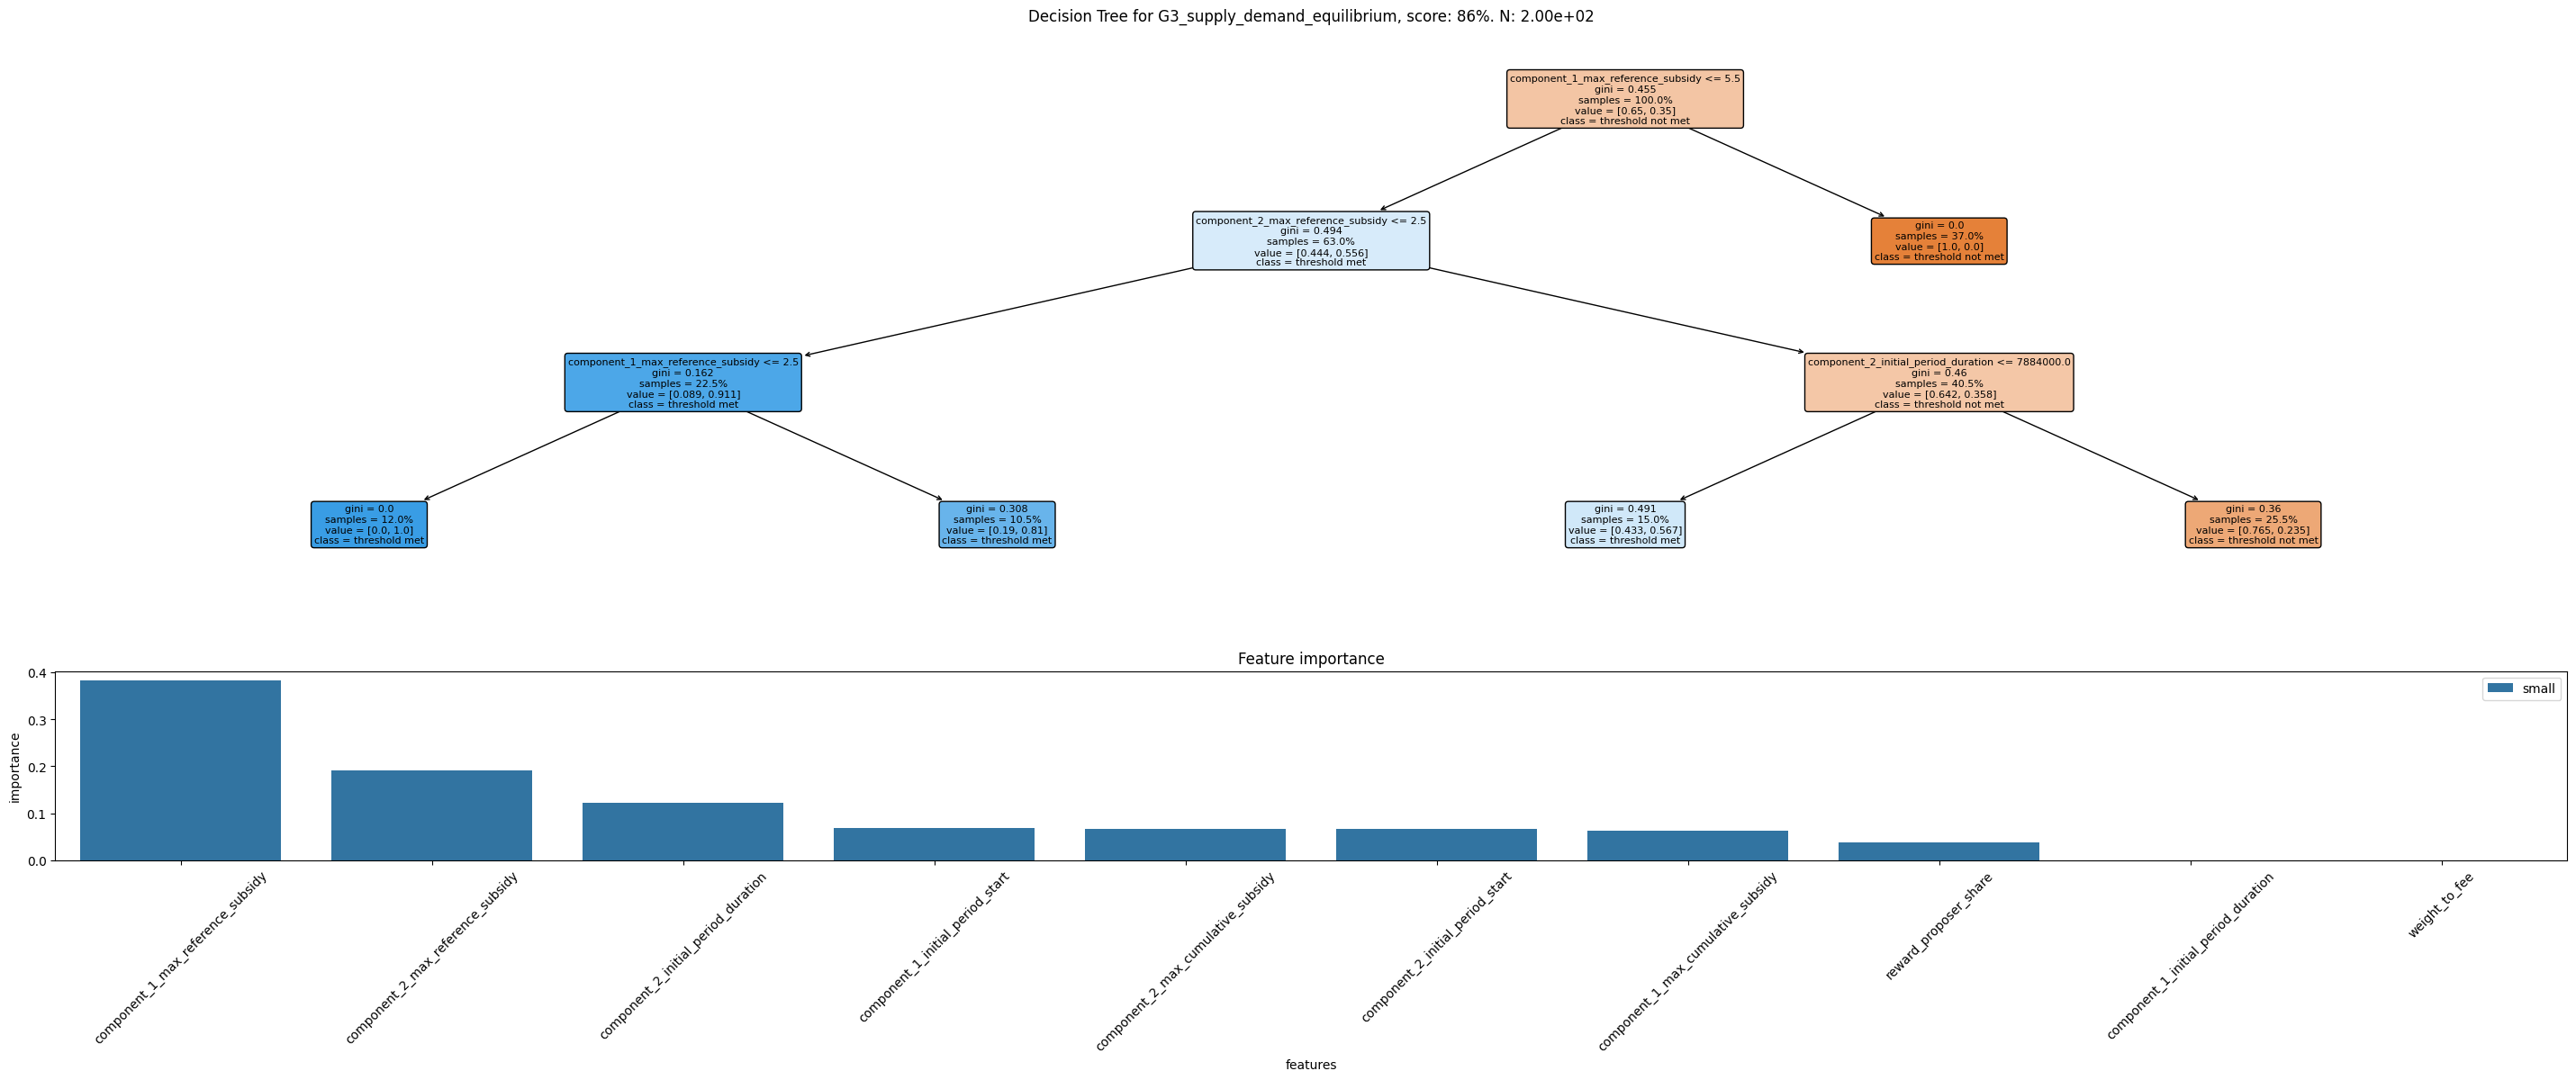

In [7]:
for goal, kpis in GOAL_KPI_GROUPS.items():
    goal_df = calculate_goal_score(agg_df, goal, goal)
    create_decision_tree_importances_plot(goal_df, goal, success_criteria='larger_than_median')


### Parameter Effect into KPIs

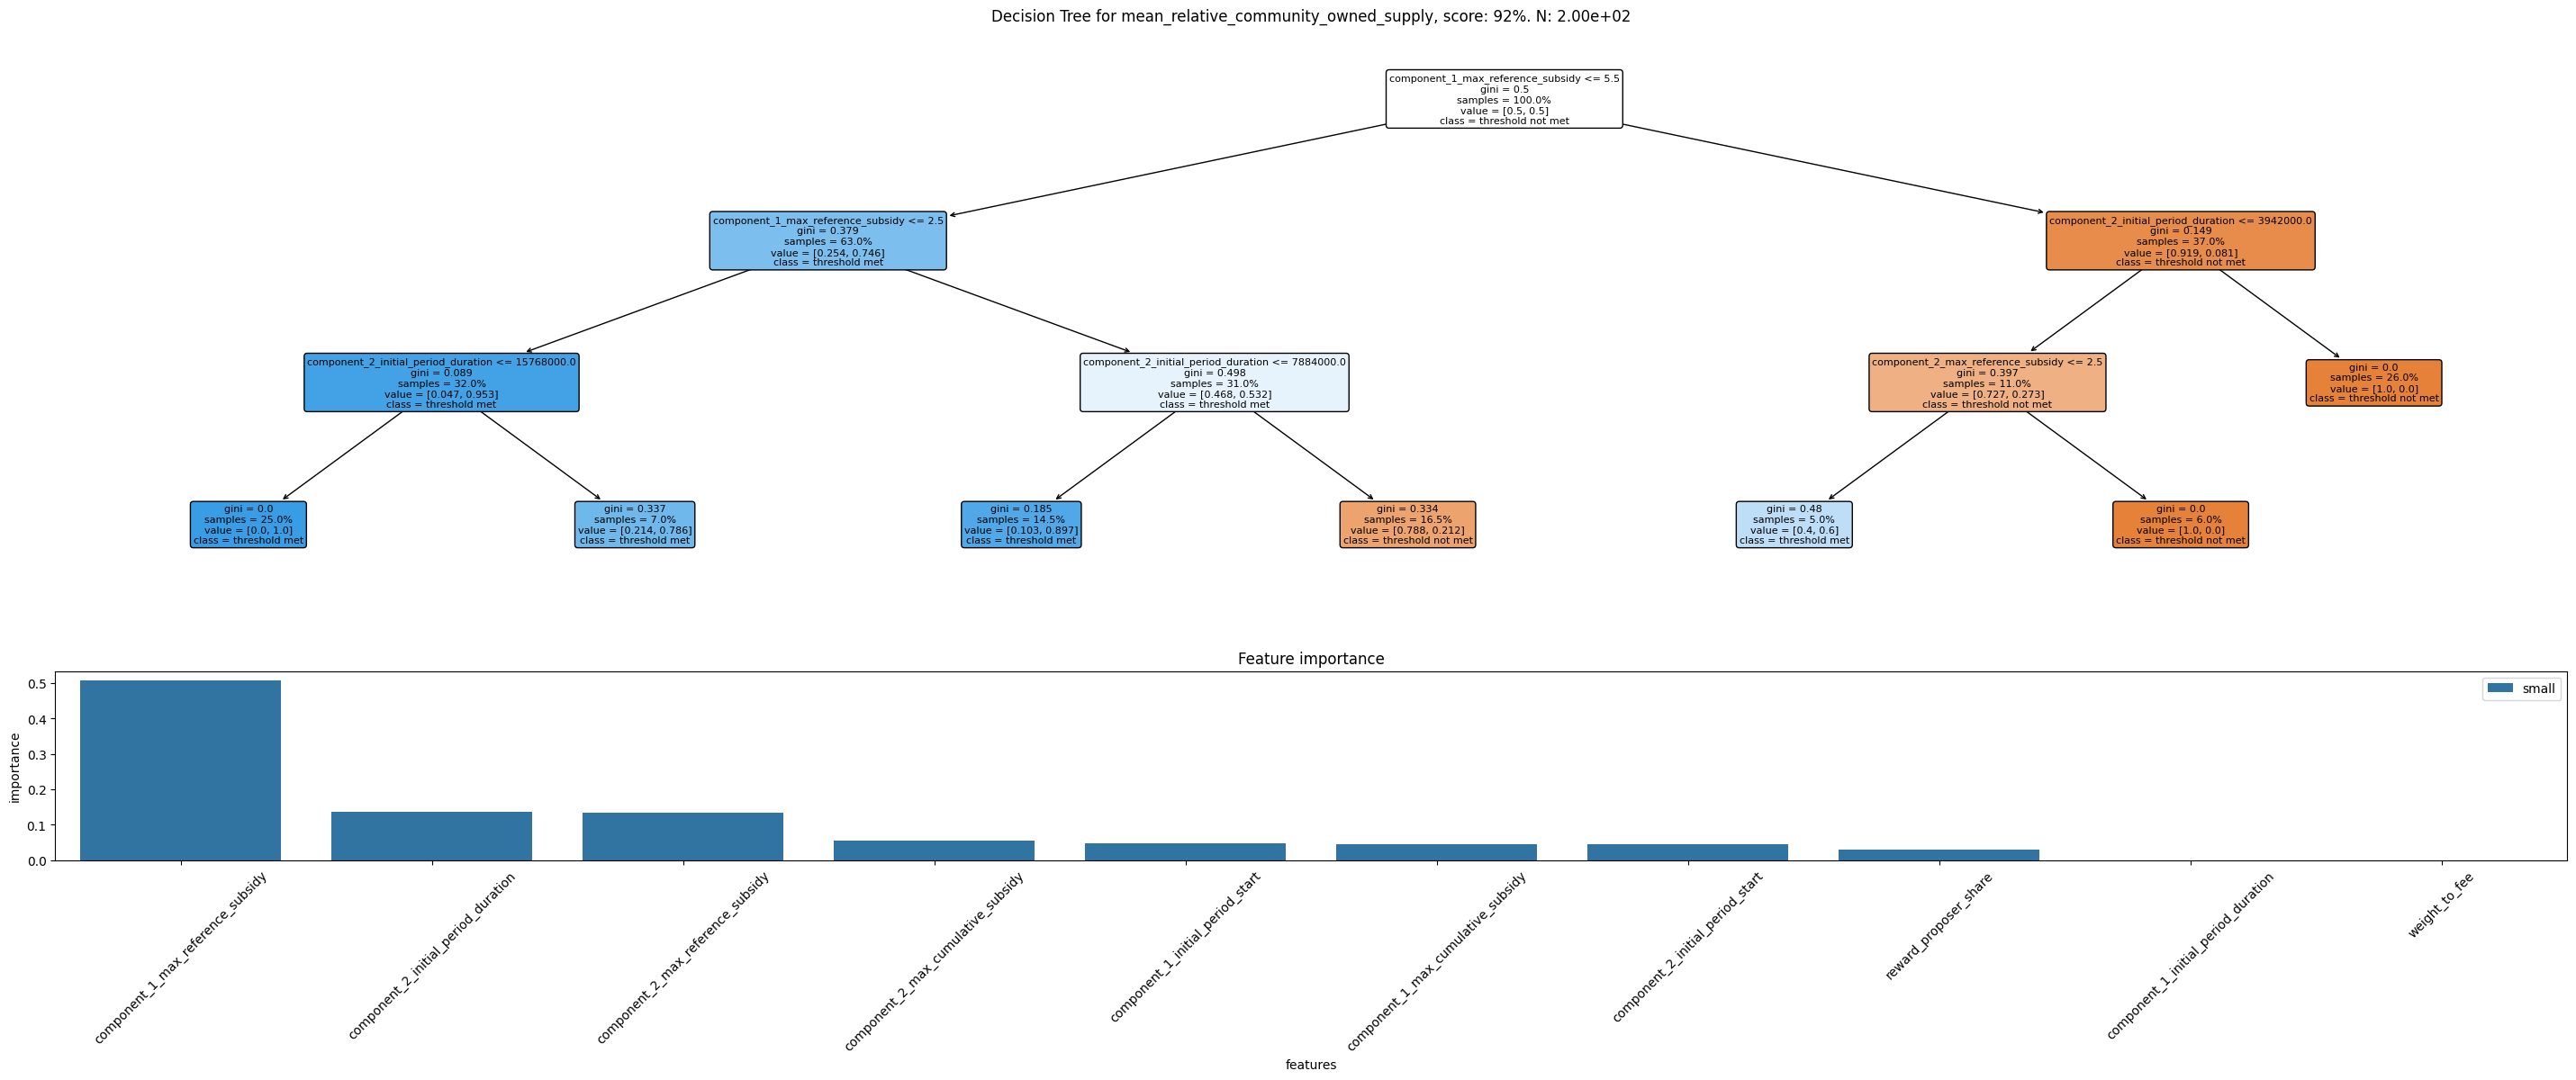

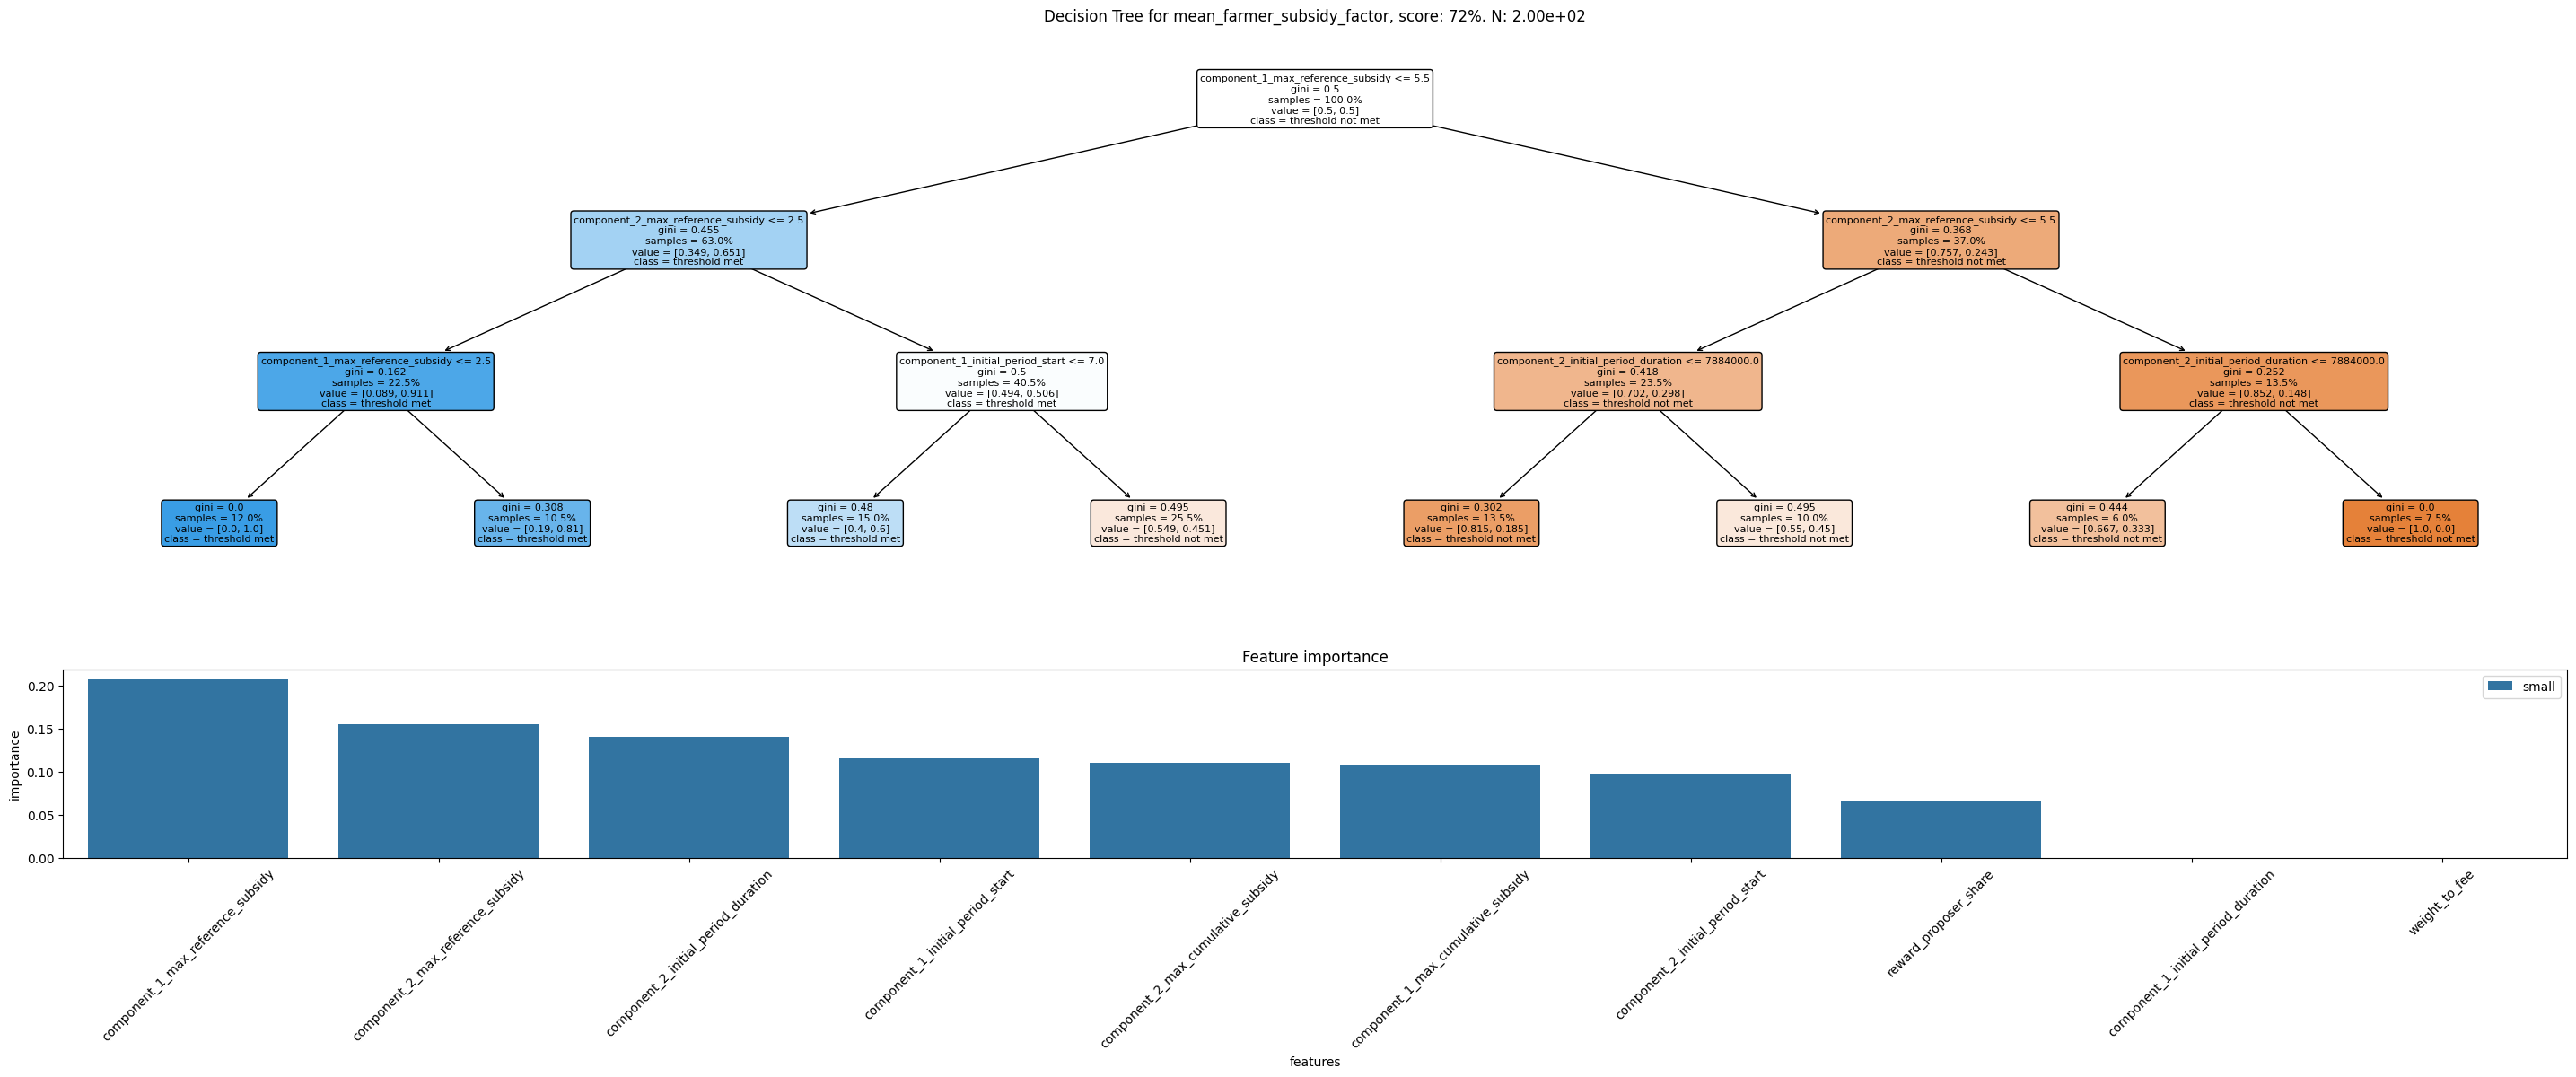

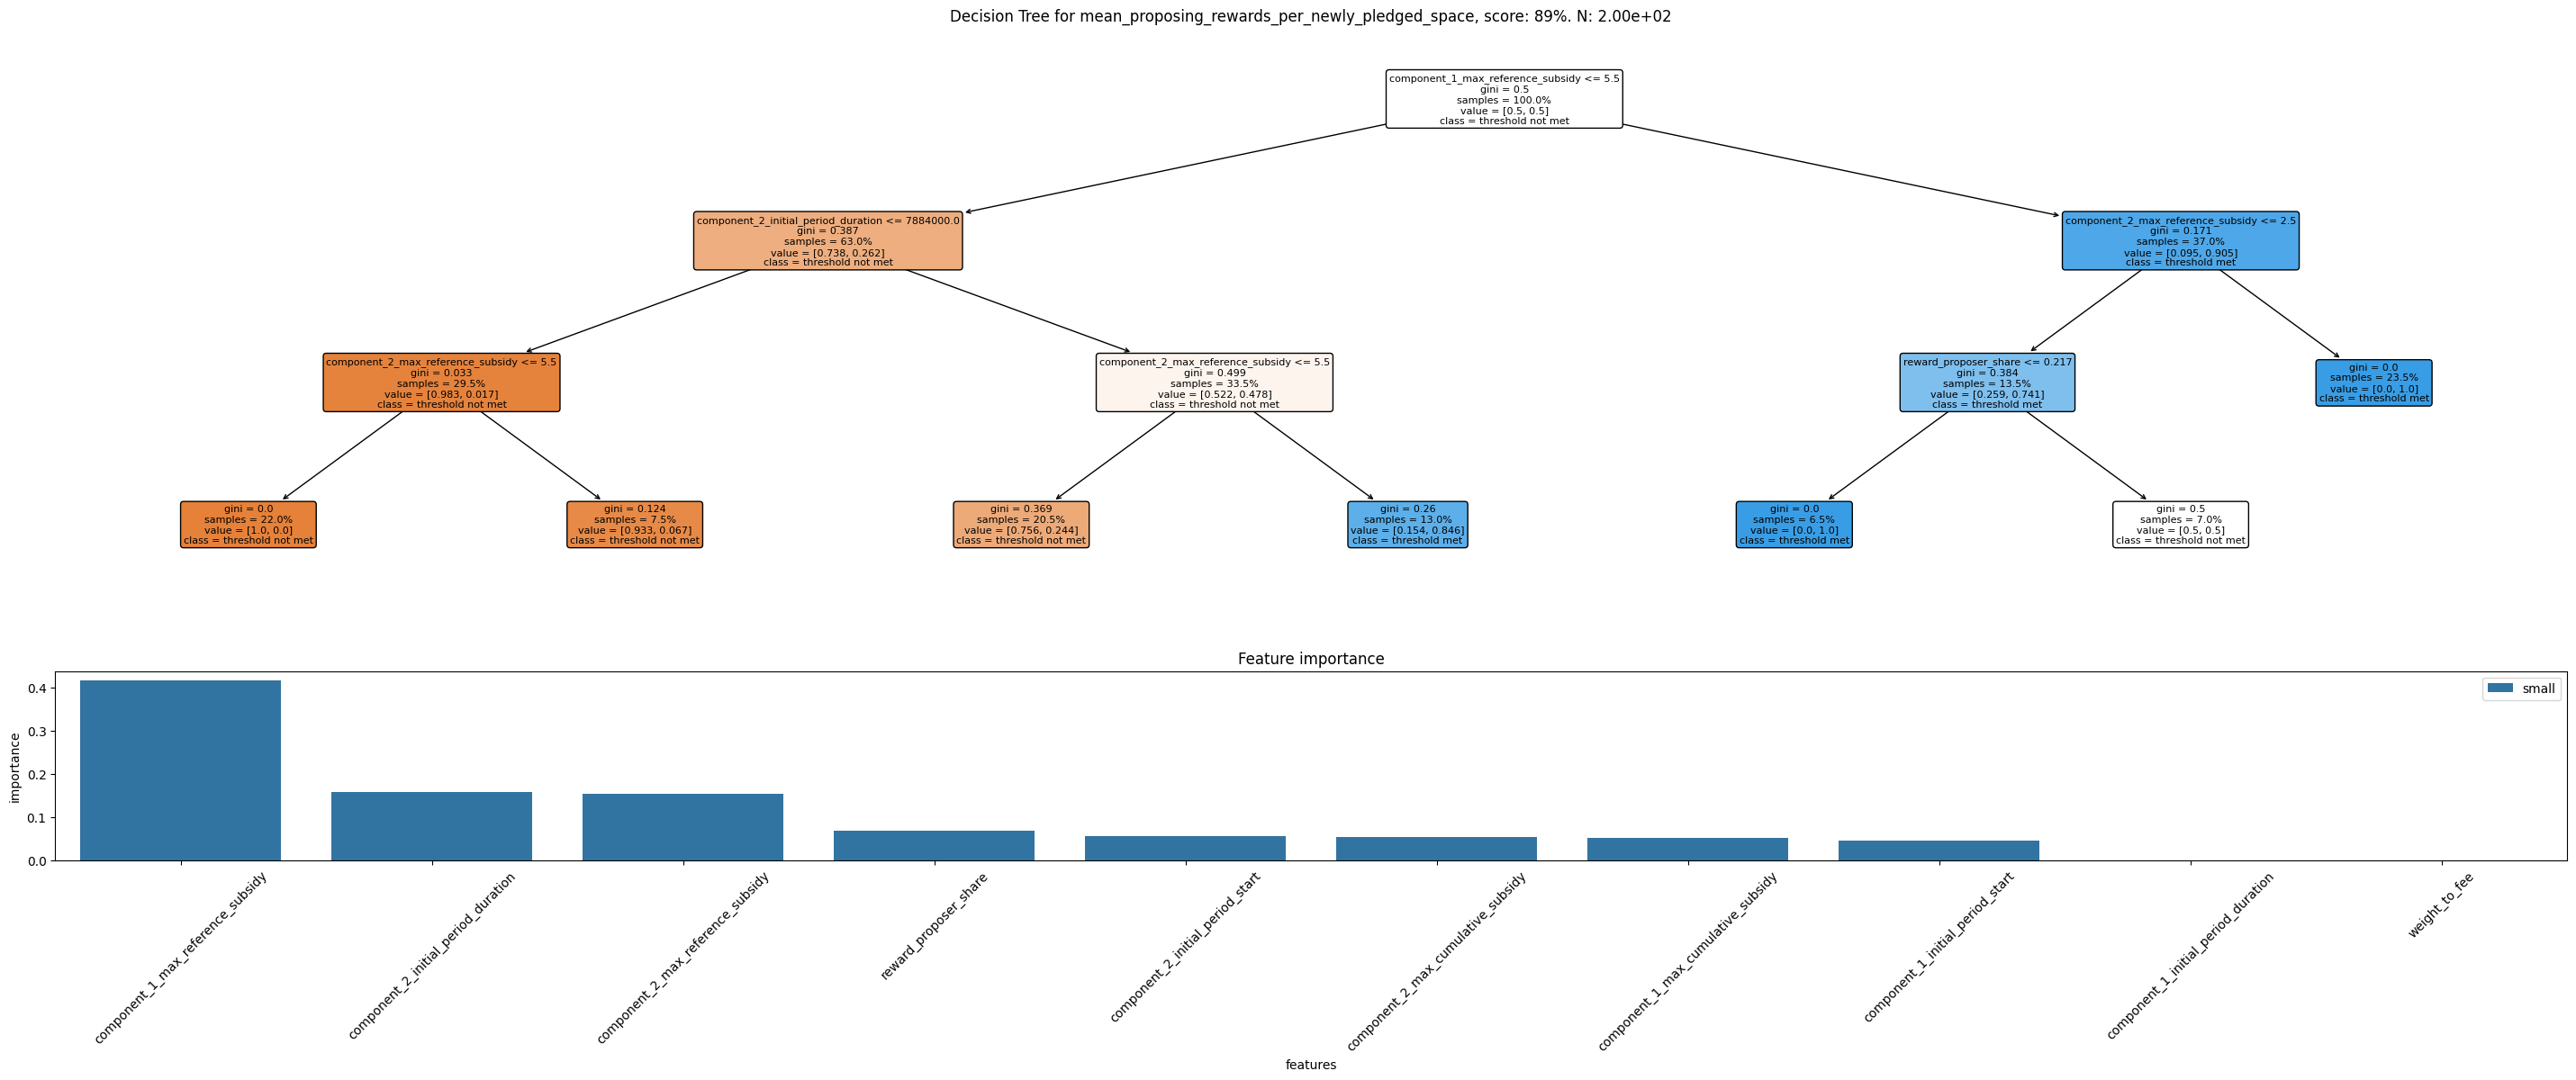

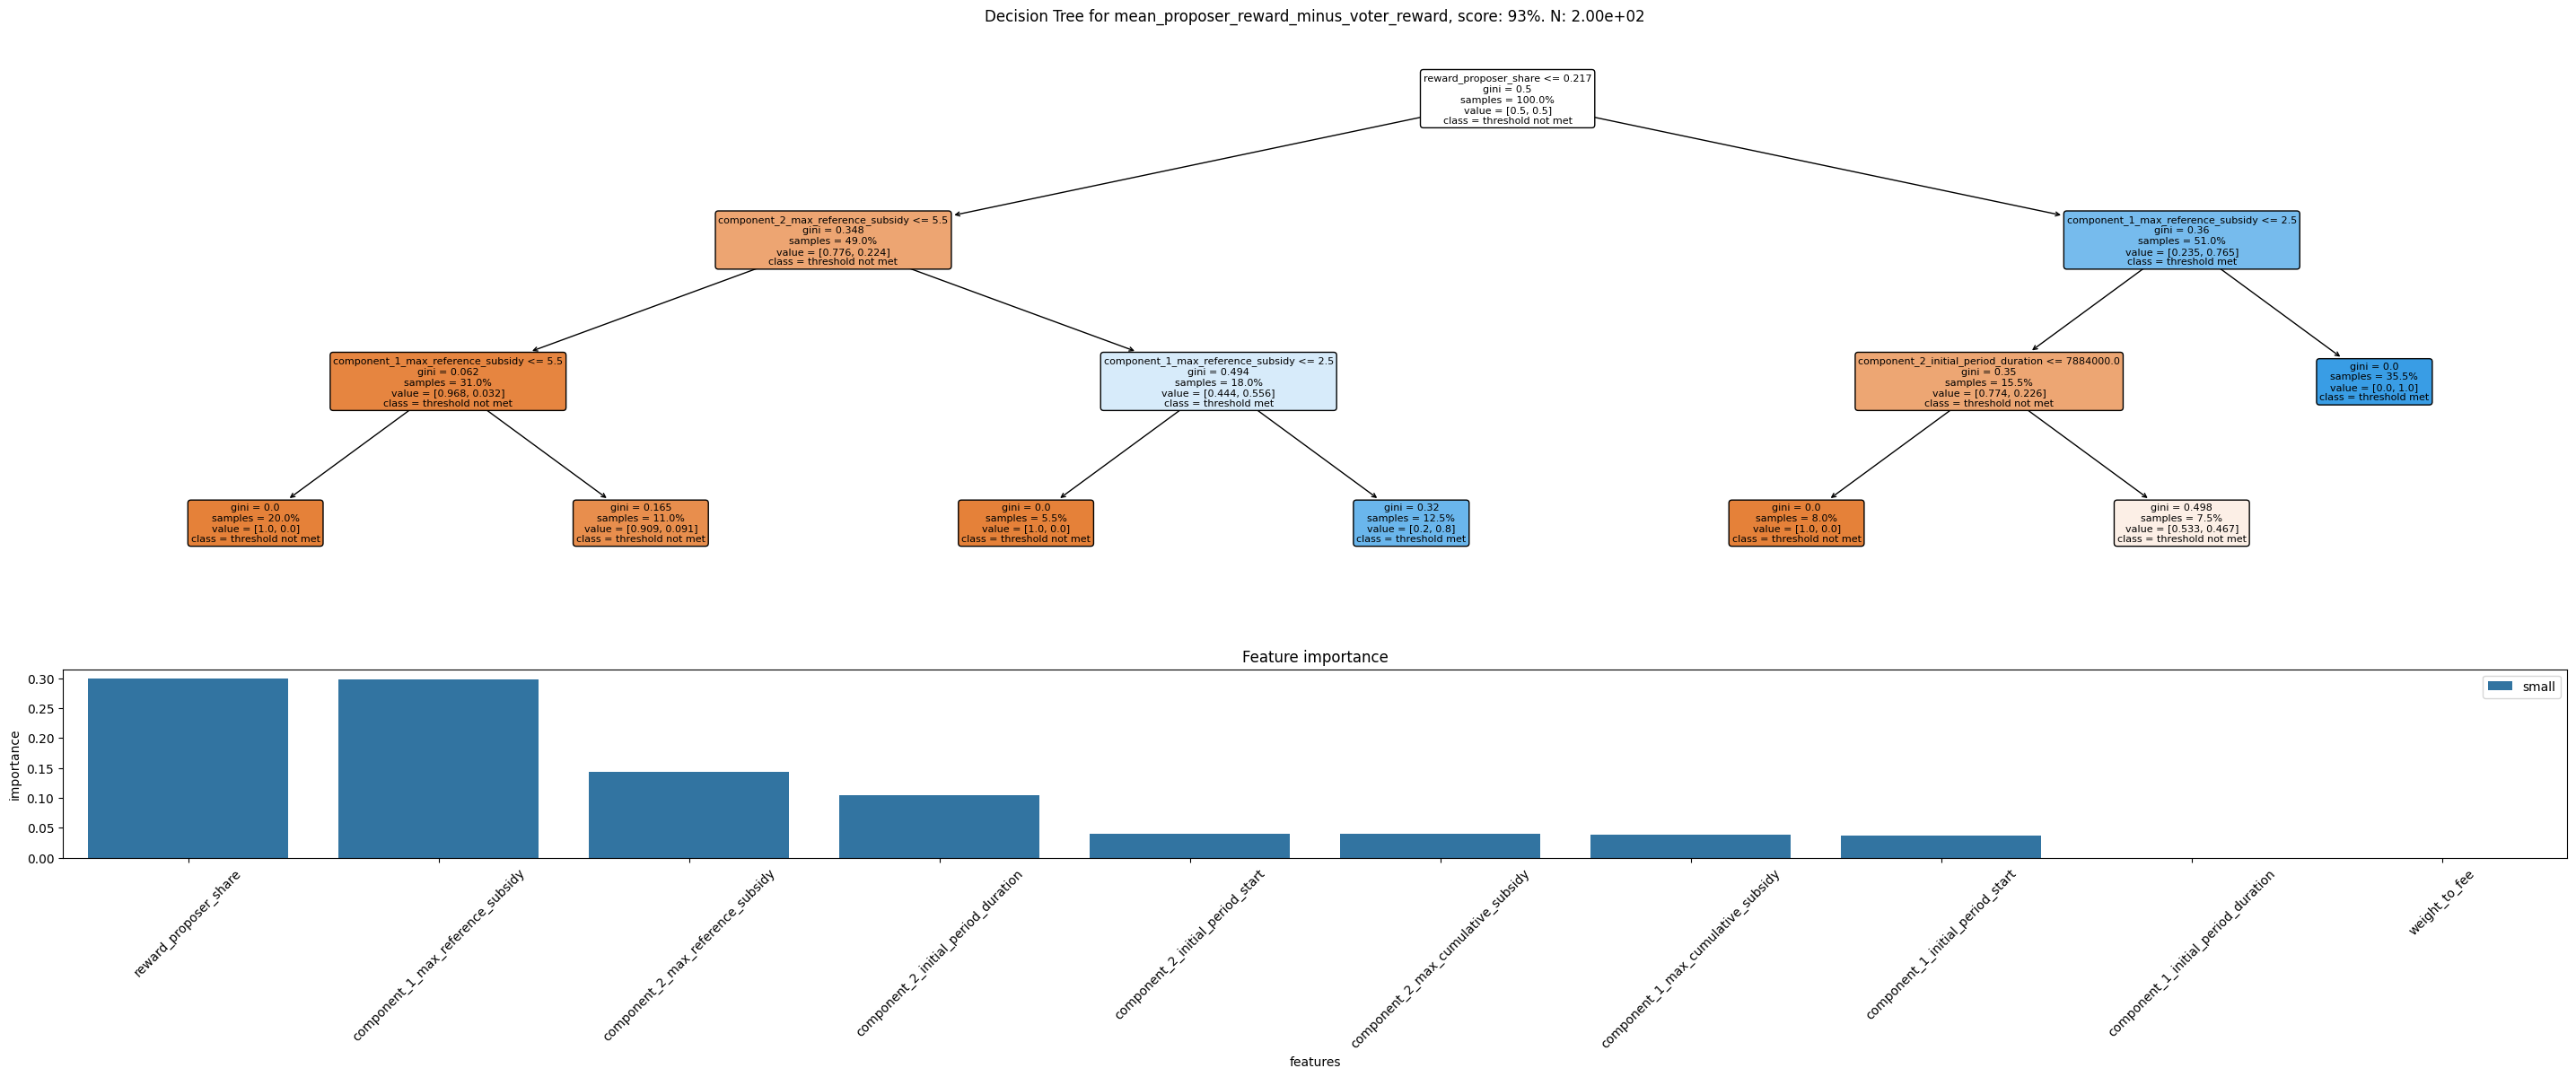

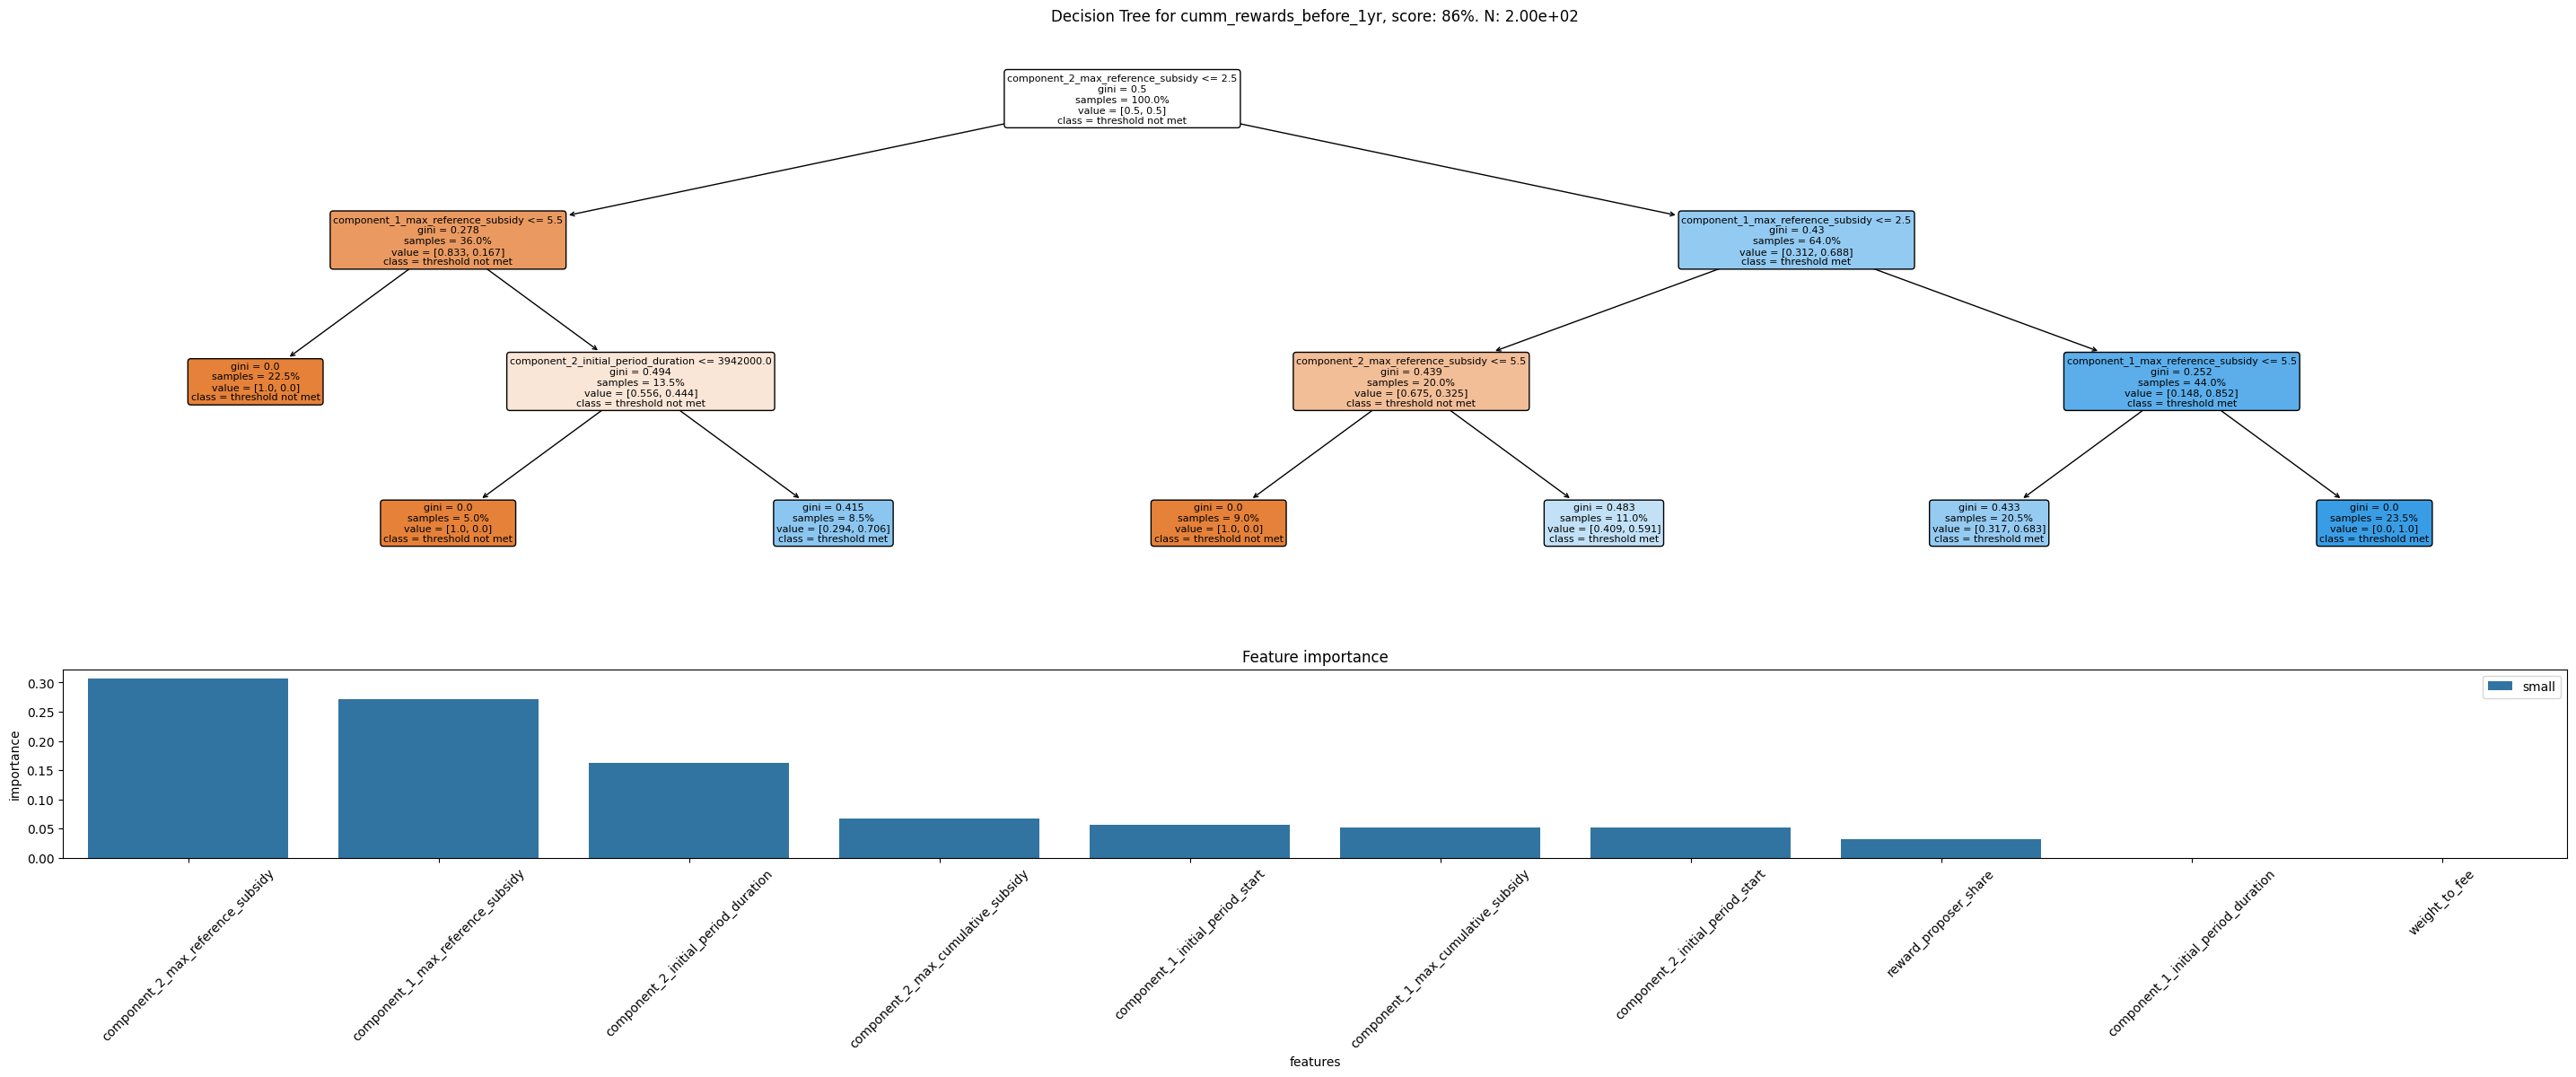

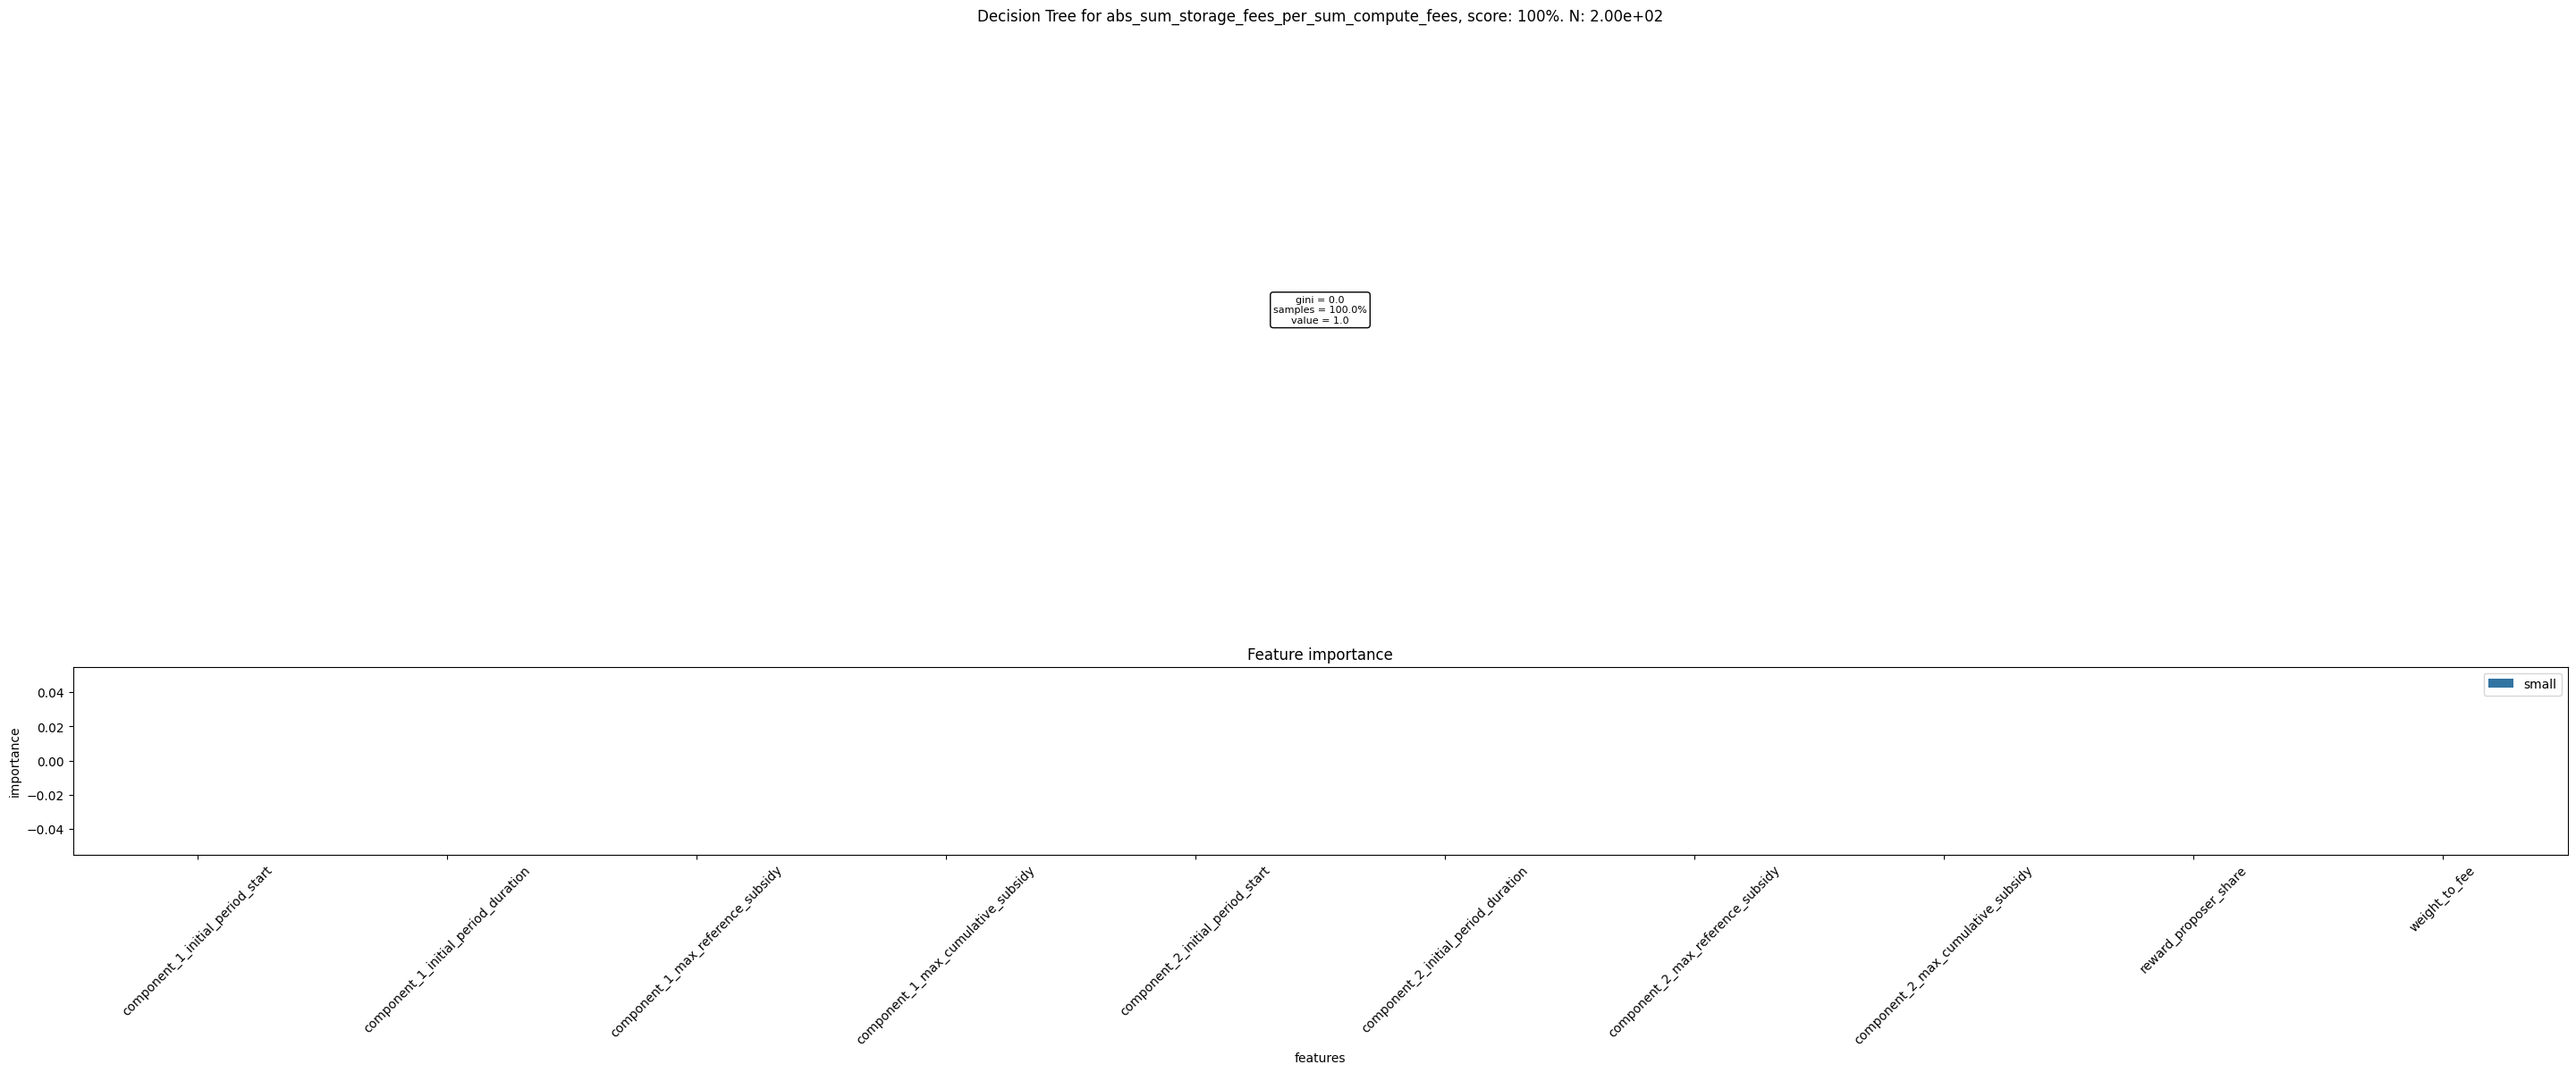

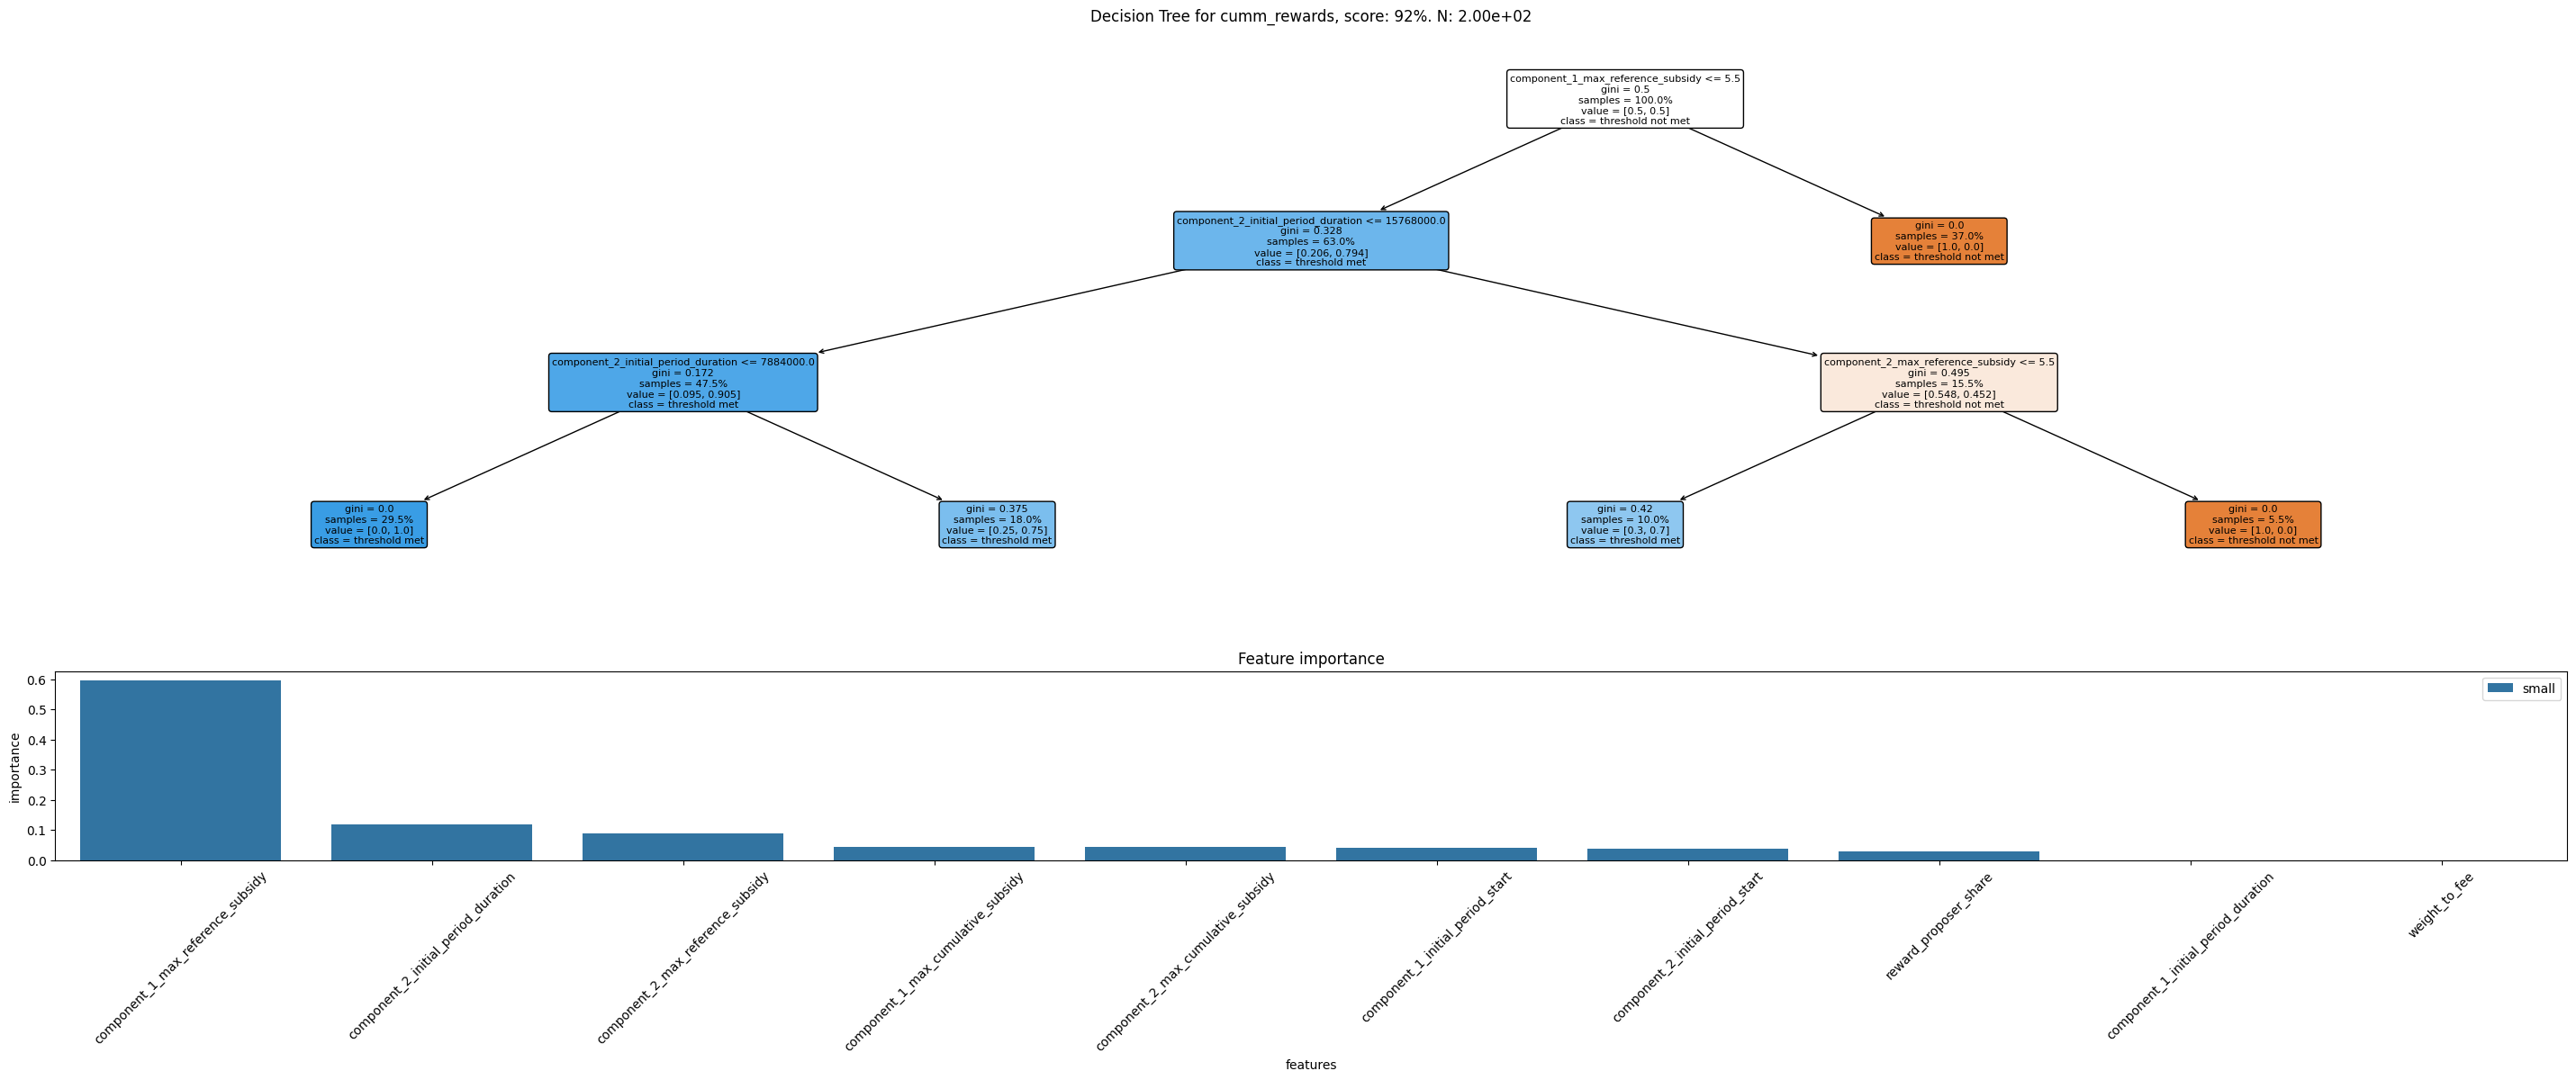

In [8]:
for col_name, (kpi_f, kpi_t) in KPI_functions.items():
    create_decision_tree_importances_plot(agg_df,
                                        col_name =col_name,
                                        success_criteria=kpi_t)
    plt.show()

### Auxiliary Visualizations

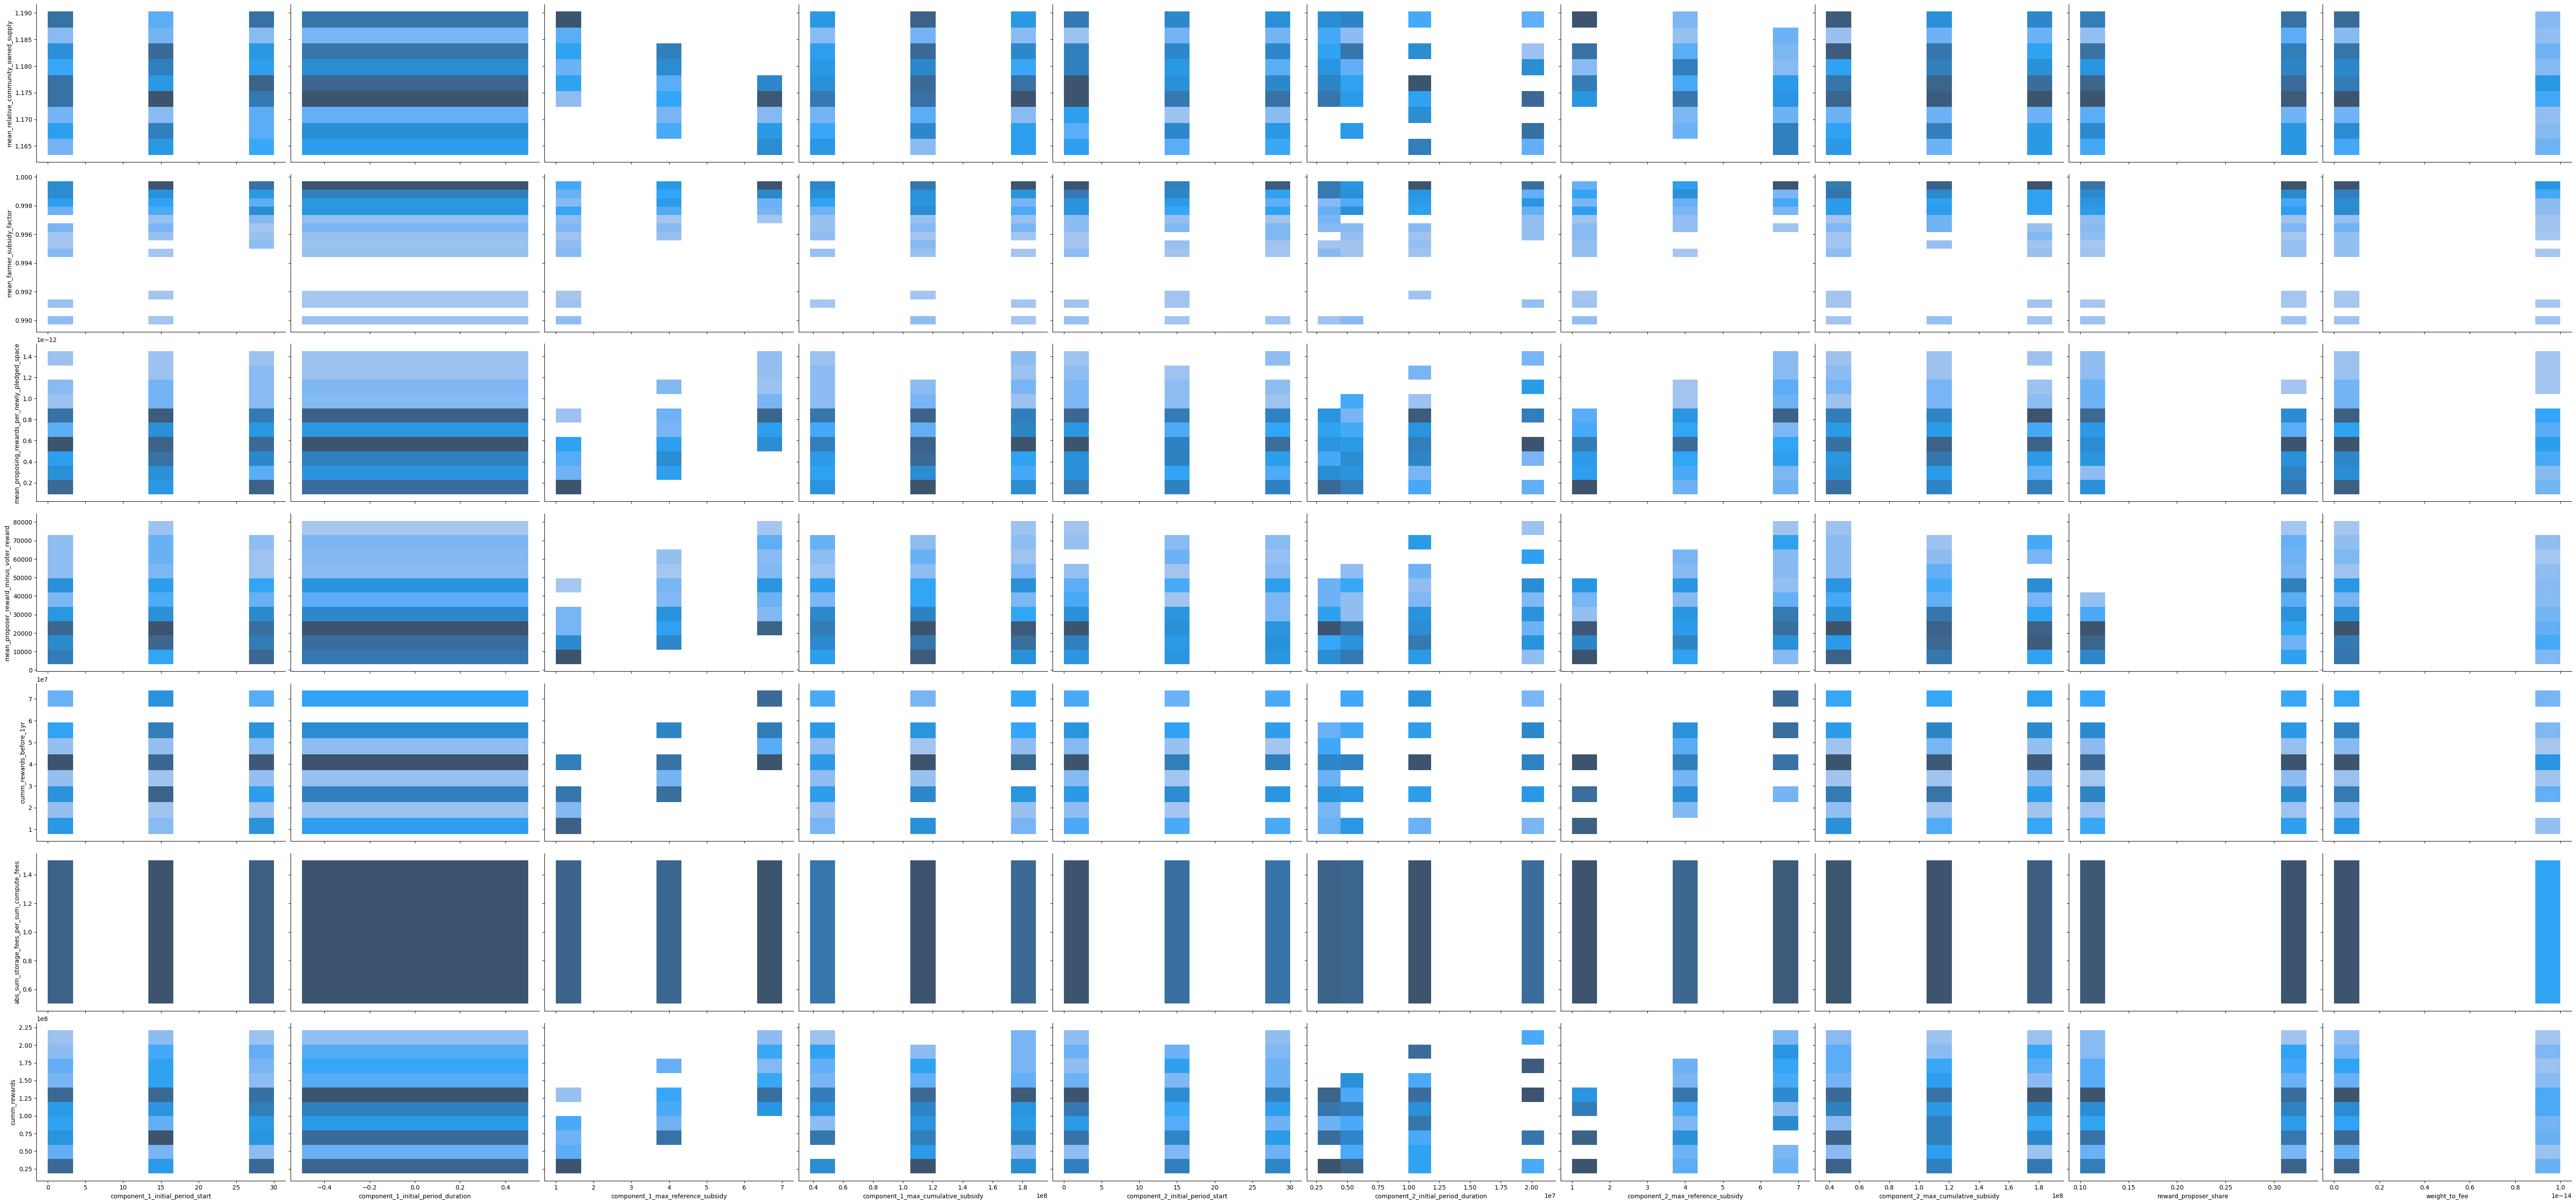

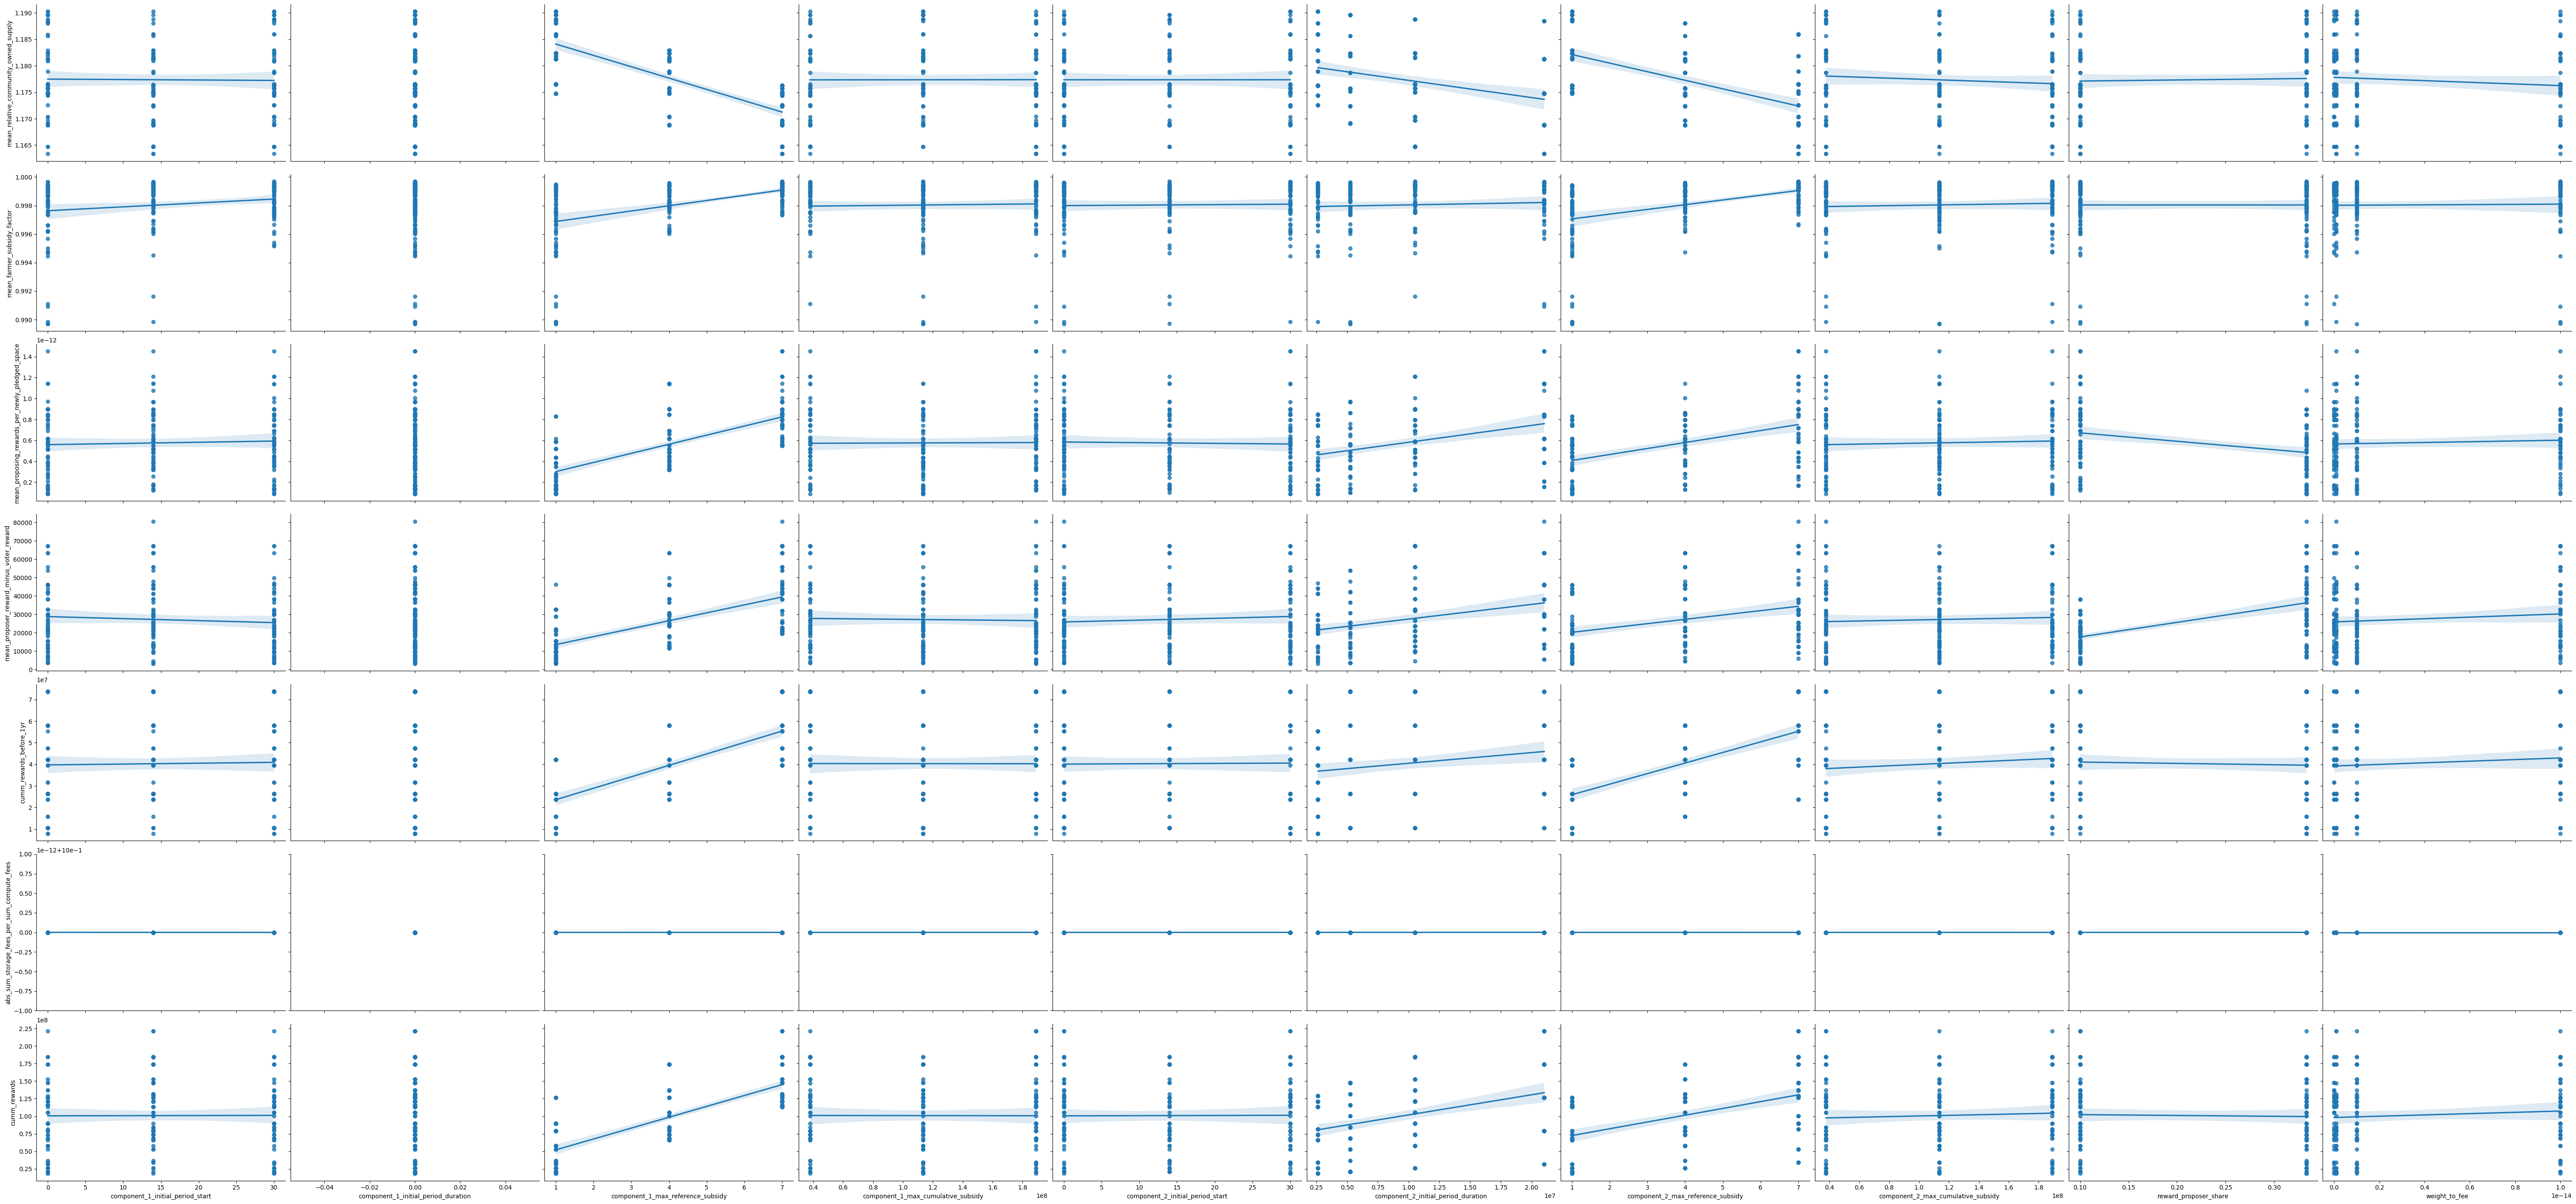

In [9]:
import seaborn as sns

N_params = len(GOVERNANCE_SURFACE_PARAMS)
N_kpis = len(KPI_functions)

N_rows = N_kpis
N_cols = N_params
HEIGHT = 4.0
ASPECT = 1.5

sns.pairplot(data=agg_df, 
             x_vars=GOVERNANCE_SURFACE_PARAMS, 
             y_vars=list(KPI_functions.keys()),
             height=HEIGHT,
             aspect=ASPECT,
             kind='hist')


sns.pairplot(data=agg_df, 
             x_vars=GOVERNANCE_SURFACE_PARAMS, 
             y_vars=list(KPI_functions.keys()),
             height=HEIGHT,
             aspect=ASPECT,
             kind='reg')


In [10]:
agg_df

simulation  subset  run  component_1_initial_period_duration  \
0             0       0    1                                    0   
1             0       1    2                                    0   
2             0       2    3                                    0   
3             0       3    4                                    0   
4             0       4    5                                    0   
..          ...     ...  ...                                  ...   
195           0     195   16                                    0   
196           0     196   17                                    0   
197           0     197   18                                    0   
198           0     198   19                                    0   
199           0     199   20                                    0   

     component_1_max_reference_subsidy  component_2_initial_period_start  \
0                                    7                                30   
1                                    7                                14   
2                                    1                                 0   
3                                    4                                30   
4                                    7                                 0   
..                                 ...                               ...   
195                                  1                                30   
196                                  4                                 0   
197                                  7                                 0   
198                                  7                                30   
199                                  1                                 0   

     reward_proposer_share  weight_to_fee  component_2_max_reference_subsidy  \
0                 0.100000   1.000000e-14                                  1   
1                 0.333333   1.000000e-16                                  1   
2                 0.100000   1.000000e-14                                  7   
3                 0.100000   1.000000e-16                                  7   
4                 0.333333   1.000000e-14                                  4   
..                     ...            ...                                ...   
195               0.100000   1.000000e-18                                  4   
196               0.100000   1.000000e-15                                  1   
197               0.333333   1.000000e-18                                  1   
198               0.333333   1.000000e-14                                  7   
199               0.100000   1.000000e-18                                  7   

     component_1_initial_period_start  component_2_initial_period_duration  \
0                                  30                           10512000.0   
1                                  30                            5256000.0   
2                                   0                           10512000.0   
3                                  30                           21024000.0   
4                                  14                           10512000.0   
..                                ...                                  ...   
195                                30                           10512000.0   
196                                14                            5256000.0   
197                                14                           10512000.0   
198                                14                            5256000.0   
199                                 0                           21024000.0   

     component_1_max_cumulative_subsidy  component_2_max_cumulative_subsidy  \
0                           189100000.0                         113460000.0   
1                           113460000.0                          37820000.0   
2                           113460000.0                         113460000.0   
3                            37820000.0          

In [11]:
for k in KPI_functions.keys():
    c = agg_df[k].value_counts()
    if len(c) <= 10:
        print(c)

abs_sum_storage_fees_per_sum_compute_fees
1.0    200
Name: count, dtype: int64


In [12]:
d = agg_df[KPI_functions.keys()].describe().T
d['mean']

mean_relative_community_owned_supply              1.177347e+00
mean_farmer_subsidy_factor                        9.980431e-01
mean_proposing_rewards_per_newly_pledged_space    5.758442e-13
mean_proposer_reward_minus_voter_reward           2.718945e+04
cumm_rewards_before_1yr                           4.027719e+07
abs_sum_storage_fees_per_sum_compute_fees         1.000000e+00
cumm_rewards                                      1.008852e+08
Name: mean, dtype: float64

In [13]:
d['std'] / d['mean']

mean_relative_community_owned_supply              0.006095
mean_farmer_subsidy_factor                        0.001905
mean_proposing_rewards_per_newly_pledged_space    0.528070
mean_proposer_reward_minus_voter_reward           0.639561
cumm_rewards_before_1yr                           0.461399
abs_sum_storage_fees_per_sum_compute_fees         0.000000
cumm_rewards                                      0.500857
dtype: float64